In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from scipy.stats import pointbiserialr
import scipy.stats as stats
import scipy.stats as ss
from scipy.stats.mstats import winsorize

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval

import warnings
warnings.filterwarnings("ignore")

## Supervised Learning Capstone: Predicting Unauthorized Status Among Noncitizens Using Census Data

My purpose for this capstone is to build a model using U.S. Census survey data that predicts a noncitizen's legal status reasonably well. I am a political scientist working in the health care policy research and advocacy space and much of my work would benefit from having the ability to filter out this population from measures of eligibility for health insurance programs in the United States. Estimating the unauthorized immigrant population is an important step in the process of calculating how many residents in the United States fall into the so-called health insurance "coverage gap." People who fall into this category are those who make too much money to qualify for Medicaid but do not make enough to qualify for government subsidized health insurance premiums on the health insurance exchanges. I am currently working on a project centered on the coverage gap and I would like to be able to measure the unauthorized population in Florida's major metropolitan areas. 

I will use data from the 2008 Survey of Income and Program Participation (SIPP), which is a national panel survey of approximately 390,000 individuals in 50,000-60,000 households over a four-year period. The U.S. government uses it to track microeconomic trends and analyze how government programs affect American households over time. The panel is asked a core set of questions in every wave that measures socioeconomic status, demographics, and receipt of and use of government spending program transfers. Each wave also includes an additional set of questions on a specific topic. The second wave covers ethnicity and immigration and it will form the basis of my analysis here.

Researchers who use the 2008 SIPP to estimate unauthorized status among noncitizens typically merge the second wave data with a larger Census dataset, either the American Community Survey (ACS) or Current Population Survey (CPS), and use a multiple imputation algorithm algorithm to predict a noncitizen's legal status. The ACS and CIPS measure respondents' citizenship status, but do not probe further to measure whether they are in the United States legally. The SIPP, on other hand, includes questions measuring whether the person came to the U.S. as a legal permanent resident (LPR) or whether they have "adjusted" to permanent status since entering the country. It also measures other forms of legal entry through various visa programs or whether the person is a refugee or asylee, but the government only provides data on LPR status. Researchers must apply for special access to the other legal status measures and pay a hefty access fee (I will rely on the publicly available measures). 

All of the Census surveys ask the same set of ethnicity, demographic, and socioeconomic status questions, so researchers may combine the SIPP and ACS (or CPS) for a multiple imputation analysis. The algorithms thus "impute" legal status in the data from the ACS or CPS in the pooled data file.
    
Pivoting from the literature, I will use machine learning algorithms to train a model to predict unauthorized status in the SIPP with the hopes of accurately predicting a noncitizen's legal status. If I am successful, I can use use the model on either the ACS or CPS to predict unauthorized status in those datasets. 

For each wave, the survey data is housed in three files: the core file, the topical module file, and the file with replicate weights. I will first merge all of three before proceeding.

In [3]:
# Reading in the topical module

sipp2008_w2tm = pd.read_stata('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/sipp2008/sipp2008w2.dta')

In [4]:
# Reading in the core data

sipp2008_w2core = pd.read_stata('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/sipp2008/sipp2008core.dta')

### Background and Potential Features

There are a few groups of social scientists who have estimated the number of unauthorized immigrants in the United States whose models are either widely used, or widely cited in the news and among policymakers. Pew Research Center's methods (PRC) are the most well known and they use a method referred to as the "residual method." It employs a combination of administrative statistics on the number of legal noncitizens from the federal government and Census survey data (ACS) to estimate the unlawful population. Their early attempts in the late 1990s were rather simple: they used either the decennial Census record of the total number noncitizens (or ACS estimates of that population) and substracted the government's official number of lawful noncitizens to calculate the unauthorized figures. 

As computer processing technology advanced, social scientists at PRC and in academia began to use multiple imputation algorithms to create more precise and granular estimates. They pooled SIPP and ACS together to impute a noncitizen's legal status, with the SIPP being the 'donor' data and the ACS being the target. Both surveys sample the national population in similar ways and use a common set of socioeconomic and demographic features to serve as predictors. The SIPP asks its noncitizen respondents whether they had legal status when they entered the country and if they have since become legal permanent residents. The ACS, on the other hand, only asks respondents if they are citizens, without probing them further to infer their legal status. Thus, in the pooled dataset, a variable measuring a noncitizen's legal status would have missing values for noncitizens from the ACS.  

For this analysis, I will use features from three unauthorized immigrant multiple imputation models that are popular in social science research. The first is from a 2014 study testing alternative methods and it uses eight features (see below). The second is a central component in a Kaiser Family Foundation (KFF) analysis estimating the number of low-income Americans who are in the health insurance "coverage gap". The KFF study is considered to be the gold standard for estimating the size of this population. The third is a model used by the Migration Policy Institute for its work measuring how federal policies impact the immigrant population. 

    Van Hook, Jennifer, James D. Bachmeier, Donna L. Coffman, and Ofer Harel. 2015. “Can We Spin Straw Into Gold? An Evaluation of Immigrant Legal Status Imputation Approaches.” Demography 52 (1): 329–54. https://doi.org/10.1007/s13524-014-0358-x.
- Family poverty level 
- education level
- Born in Mexico
- Years of U.S. residence
- age
- gender
- Number of functional limitations (disabilities)
- Poor health

The Van Hook et al. group's feature set has the fewest dimensions, but we are not able to completely replicate it. Looking into the future stages of this project, the ACS does not include measures of Americans' health status. On the other hand, most of the remaining features overlap with the two models below.

    Garfield, Rachel, Kendal Orgera, and Anthony Damico. 2019. “The Coverage Gap: Uninsured Poor Adults in States That Do Not Expand Medicaid.” Issue brief. Washington, D.C.: Kaiser Family Foundation. https://www.kff.org/medicaid/issue-brief/the-coverage-gap-uninsured-poor-adults-in-states-that-do-not-expand-medicaid/.
- Year of US entry,
- Job industry classification,
- State of residence,
- Family Poverty Level,
- Ownership or rental of residence,
- Presence of at least one citizen in household,
- Number of occupants in the household (< or >= six occupants),
- Whether all household occupants are related,
- Number of workers in household,
- Health insurance coverage status,
- Gender
- Ethnicity-Hispanic or Latino Origin
- Age Group
- Age Group * Gender
- Age Group * Insurance Coverage * Gender

We can replicate this model completely because both the SIPP and ACS have all of the features. 

    Capps, Randy, James D. Bachmeier, Michael Fix, and Jennifer Van Hook. 2013. “A Demographic, Socioeconomic, and Health Coverage Profile of Unauthorized Immigrants in the United States.” 5. Washington D.C.: Migration Policy Institute. https://www.migrationpolicy.org/research/demographic-socioeconomic-and-health-coverage-profile-unauthorized-immigrants-united-states.
- world region of birth 
- duration of US residence 
- English language proficiency
- age
- sex 
- marital status
- parental status
- household size
- educational attainment
- homeownership
- insurance coverage
- labor force status
- income-to-poverty ratio
- US state/region of residence

### Variables to keep from core file:

Identifiers and weights:
'ssuid' , 'epppnum' , 'rfid' , 'wpfinwgt', 'srefmon',

Demographic:
'tage' ,'ebornus' , 'ecitizen' , 'tftotinc' , 'rfpov' ,
'ejbind1' , 'eorigin' , 'tfipsst', 'epdjbthn' , 'etenure' ,
'esex' , 'tmetro', 'tjbocc1', 'ehowwell', 'eeducate', 'epnspous', 'epnmom', 'epndad', 'errp', 'esftype', 'espeak', esfr', 'shhadid', 'eftype'

Insurance Vars:
'rchampm' , 'er20' , 'er03a' , 'er01a' , 'rprvhi' ,
'rprvhi2' , 'emcocov' , 'ecrmth' , 'ecdmth'

### Variables to keep from topical file: 

identifiers:
'ssuid', 'epppnum',

migration variables:
'timstat', 'eadjust','tmoveus', 'tbrstate', 'tmovyryr', 'bcntry'

In [5]:
# Creating smaller dataset with variables from core file

sipp2008_w2core_small = sipp2008_w2core[['ssuid' , 'epppnum' , 'rfid' , 'rfid2', 'wpfinwgt', 'tage', 'ebornus',
                                         'ecitizen', 'tftotinc', 'rfpov', 'ejbind1', 'epdjbthn', 'tjbocc1', 'erace',
                                         'eorigin', 'tfipsst', 'etenure','esex', 'tmetro', 
                                         'rchampm', 'er20', 'er03a', 'er01a', 'rprvhi', 'rprvhi2','emcocov', 
                                         'ecrmth', 'ecdmth','srefmon', 'eeducate', 'espeak', 'ehowwell', 'epnspous', 
                                         'epnmom', 'epndad', 'errp', 'esftype', 'esfr', 'shhadid', 'eftype', 
                                         'efkind', 'efspouse', 'ehiowner']]

In [6]:
# Checking to see if the data looks OK.

sipp2008_w2tm.head()

,ssuseq,ssuid,spanel,swave,srotaton,tfipsst,shhadid,eoutcome,rfid,rfid2,...,erebate,arebate,erbamth,arbamth,erbatamt,arbatamt,erbattyp,arbattyp,erebatoc,arebatoc
0,1,019128000276,2008,2,2,12,11,201,4,4,...,2,0,-1,0,0,0,-1,0,-1,0
1,1,019128000276,2008,2,2,12,11,201,4,4,...,2,0,-1,0,0,0,-1,0,-1,0
2,1,019128000276,2008,2,2,12,11,201,4,4,...,-1,0,-1,0,0,0,-1,0,-1,0
3,2,019128000334,2008,2,2,12,11,201,4,4,...,1,0,4,0,600,0,2,0,2,0
4,3,019128000932,2008,2,2,22,11,201,4,4,...,2,0,-1,0,0,0,-1,0,-1,0


In [7]:
# Creating smaller topical module files with migration variables

sipp2008_w2tm_small = sipp2008_w2tm[['ssuid', 'epppnum', 'timstat', 'eadjust','tmoveus', 'tbrstate', 'tmovyryr']]

In [8]:
# Reading in the replicate weight files

sipp2008_w2_rw = pd.read_stata('/Users/machilders/Box Sync/Data Science/Thinkful/Data Files/sipp2008/rw08w2.dta')

In [9]:
sipp2008_w2_rw.head()

,ssuid,spanel,swave,srefmon,epppnum,repwgt1,repwgt2,repwgt3,repwgt4,repwgt5,...,repwgt111,repwgt112,repwgt113,repwgt114,repwgt115,repwgt116,repwgt117,repwgt118,repwgt119,repwgt120
0,019128000276,2008,2,1,0101,2040.7541,5551.7528,2119.0897,1835.0505,2008.5523,...,2137.3179,5662.3515,5582.8150,5723.1093,2107.6800,6089.2609,5612.6844,6430.2347,5413.1362,1810.1130
1,019128000276,2008,2,2,0101,2085.9348,5665.7759,2152.8643,1861.6643,2036.1622,...,2177.7639,5762.0629,5682.3981,5795.3878,2135.6026,6184.0565,5674.9338,6481.0159,5405.5585,1834.6934
2,019128000276,2008,2,3,0101,2115.7526,5773.8978,2225.4883,1894.2444,2099.8113,...,2209.2974,5792.6937,5767.4380,5986.5837,2200.2664,6194.7575,5790.4998,6626.1138,5564.5842,1851.5967
3,019128000276,2008,2,4,0101,2062.7738,5759.3346,2175.7926,1840.2327,2061.9449,...,2168.3851,5672.1106,5573.4326,5889.4111,2145.7929,5991.2279,5706.9871,6603.9234,5416.1095,1817.2770
4,019128000276,2008,2,1,0102,2040.7541,5551.7528,2119.0897,1835.0505,2008.5523,...,2137.3179,5662.3515,5582.8150,5723.1093,2107.6800,6089.2609,5612.6844,6430.2347,5413.1362,1810.1130


In [10]:
# Checking the data types in the core file.

sipp2008_w2core_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392702 entries, 0 to 392701
Data columns (total 43 columns):
ssuid       392702 non-null object
epppnum     392702 non-null object
rfid        392702 non-null int16
rfid2       392702 non-null int16
wpfinwgt    392702 non-null float64
tage        392702 non-null int8
ebornus     392702 non-null int8
ecitizen    392702 non-null int8
tftotinc    392702 non-null int32
rfpov       392702 non-null int32
ejbind1     392702 non-null int16
epdjbthn    392702 non-null int8
tjbocc1     392702 non-null int16
erace       392702 non-null int8
eorigin     392702 non-null int8
tfipsst     392702 non-null int8
etenure     392702 non-null int8
esex        392702 non-null int8
tmetro      392702 non-null int8
rchampm     392702 non-null int8
er20        392702 non-null int8
er03a       392702 non-null int8
er01a       392702 non-null int8
rprvhi      392702 non-null int8
rprvhi2     392702 non-null int8
emcocov     392702 non-null int8
ecrmth      392702

### Creating identifier variable for respondents

Every person is assigned a household number and a person number within that household. We can combine them to create an ID variable. The household and person number variables are strings, so we can add them together and convert to a numeric column later. We will do this for each of the three files that we have read into Pandas before we combine them into one for the analysis. 

In [11]:
# Unique identifiers for respondents can be created by concatenating ssuid (household number) and 
# epppnum (person number)
# These two columns are objects, but we will convert them to numeric while combining them. 

sipp2008_w2core_small['pid'] = pd.to_numeric(sipp2008_w2core_small['ssuid'].str.cat(sipp2008_w2core_small['epppnum']))

In [12]:
sipp2008_w2core_small.head()

,ssuid,epppnum,rfid,rfid2,wpfinwgt,tage,ebornus,ecitizen,tftotinc,rfpov,...,epndad,errp,esftype,esfr,shhadid,eftype,efkind,efspouse,ehiowner,pid
0,019128000276,0101,1,1,3903.1606,29,2,2,381,1452,...,9999,1,-1,0,11,1,1,102,1,191280002760101
1,019128000276,0101,2,2,3979.0720,29,2,2,381,1424,...,9999,1,-1,0,11,1,1,102,1,191280002760101
2,019128000276,0101,3,3,4056.2319,29,2,2,381,1410,...,9999,1,-1,0,11,1,1,102,1,191280002760101
3,019128000276,0101,4,4,3973.9954,29,2,2,381,1416,...,9999,1,-1,0,11,1,1,102,1,191280002760101
4,019128000276,0102,1,1,3903.1606,32,2,2,381,1452,...,9999,3,-1,0,11,1,1,102,2,191280002760102


In [13]:
# Creating a pid variable in smaller topical module

sipp2008_w2tm_small['pid'] = pd.to_numeric(sipp2008_w2tm_small['ssuid'] + sipp2008_w2tm_small['epppnum'])

In [14]:
sipp2008_w2tm_small[['pid', 'ssuid', 'epppnum']].head()

,pid,ssuid,epppnum
0,191280002760101,019128000276,0101
1,191280002760102,019128000276,0102
2,191280002760103,019128000276,0103
3,191280003340102,019128000334,0102
4,191280009320101,019128000932,0101


In [15]:
sipp2008_w2tm_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98504 entries, 0 to 98503
Data columns (total 8 columns):
ssuid       98504 non-null object
epppnum     98504 non-null object
timstat     98504 non-null int8
eadjust     98504 non-null int8
tmoveus     98504 non-null int16
tbrstate    98504 non-null int16
tmovyryr    98504 non-null int16
pid         98504 non-null int64
dtypes: int16(3), int64(1), int8(2), object(2)
memory usage: 3.8+ MB


In [16]:
sipp2008_w2_rw['pid'] = pd.to_numeric(sipp2008_w2_rw['ssuid'] + sipp2008_w2_rw['epppnum'])

In [17]:
# Checking the PID column to see if they concatenated correctly.

sipp2008_w2_rw.pid.describe()

count    3.927020e+05
mean     5.534897e+15
std      2.638546e+15
min      1.912800e+14
25%      3.859251e+15
50%      5.665620e+15
75%      7.399254e+15
max      9.559590e+15
Name: pid, dtype: float64

#### TM Reference Month

The core file and replicate weights files include a column indicating which month that the interview took place in. Each survey wave takes place over four months and respondents are interviewed once every month. SIPP includes a column, 'srefmon', which can equal 1, 2, 3, or 4, depending on which of the wave's four months in which the respondent was interviewed. The topical module (TM) questions are typically deployed in the fourth month of each wave, but it lacks a column for the reference month ('srefmon'). To prep the TM file for merging with the core and replicate weights files, we should create a 'srefmon' column that equals four for every respondent. 

In [18]:
sipp2008_w2tm_small['srefmon'] = 4

In [19]:
sipp2008_w2tm_small.head()

,ssuid,epppnum,timstat,eadjust,tmoveus,tbrstate,tmovyryr,pid,srefmon
0,019128000276,0101,2,2,16,567,2004,191280002760101,4
1,019128000276,0102,2,2,16,567,2004,191280002760102,4
2,019128000276,0103,-1,-1,-1,-1,-1,191280002760103,4
3,019128000334,0102,-1,-1,-1,48,2008,191280003340102,4
4,019128000932,0101,1,-1,15,568,2004,191280009320101,4


We are going to drop all observations in reference months 1-3 in the core and replicate weights data files in order to allow us to merge them with the topical module file. The topical module file only contains data from the fourth reference month.

In [20]:
sipp2008_w2_rw = sipp2008_w2_rw[sipp2008_w2_rw.srefmon == 4]

In [21]:
sipp2008_w2_rw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98504 entries, 3 to 392701
Columns: 126 entries, ssuid to pid
dtypes: float64(120), int16(1), int64(1), int8(2), object(2)
memory usage: 93.6+ MB


In [22]:
sipp2008_w2core_small = sipp2008_w2core_small[sipp2008_w2core_small.srefmon == 4]

In [23]:
sipp2008_w2core_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98504 entries, 3 to 392701
Data columns (total 44 columns):
ssuid       98504 non-null object
epppnum     98504 non-null object
rfid        98504 non-null int16
rfid2       98504 non-null int16
wpfinwgt    98504 non-null float64
tage        98504 non-null int8
ebornus     98504 non-null int8
ecitizen    98504 non-null int8
tftotinc    98504 non-null int32
rfpov       98504 non-null int32
ejbind1     98504 non-null int16
epdjbthn    98504 non-null int8
tjbocc1     98504 non-null int16
erace       98504 non-null int8
eorigin     98504 non-null int8
tfipsst     98504 non-null int8
etenure     98504 non-null int8
esex        98504 non-null int8
tmetro      98504 non-null int8
rchampm     98504 non-null int8
er20        98504 non-null int8
er03a       98504 non-null int8
er01a       98504 non-null int8
rprvhi      98504 non-null int8
rprvhi2     98504 non-null int8
emcocov     98504 non-null int8
ecrmth      98504 non-null int8
ecdmth      9

In [24]:
# Merging the core and replicate weight files together

sipp2008_corerw = pd.merge(sipp2008_w2_rw, sipp2008_w2core_small, how = 'left', on = 'pid')

In [25]:
sipp2008_corerw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98504 entries, 0 to 98503
Columns: 169 entries, ssuid_x to ehiowner
dtypes: float64(121), int16(10), int32(2), int64(1), int8(31), object(4)
memory usage: 101.0+ MB


In [26]:
# Merging the three files together (core, topical module, and replicate weights)

sipp2008w2_all = pd.merge(sipp2008_corerw, sipp2008_w2tm_small, how = 'left', on = 'pid')

In [27]:
sipp2008w2_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98504 entries, 0 to 98503
Columns: 177 entries, ssuid_x to srefmon
dtypes: float64(121), int16(13), int32(2), int64(2), int8(33), object(6)
memory usage: 104.0+ MB


### Feature Engineering and Data Wranging

Now that the files are merged together, let's begin wrangling the data to use in machine learning algorithms. 

### KFF Features

- Year of US entry,
- Job industry classification,
- State of residence,
- Family Poverty Level,
- Ownership or rental of residence,
- Presence of at least one citizen in household,
- Number of occupants in the household (< or >= six occupants),
- Whether all household occupants are related,
- Number of workers in household,
- Health insurance coverage status,
- Gender
- Ethnicity
- Age Group
- Age Group * Gender
- Age Group * Insurance Coverage * Gender

#### State of Residence
The six states with the highest immigrant populations are:
- 6: California
- 12: Florida
- 17: Illinois
- 34: New Jersey
- 36: New York
- 48: Texas
- Rest of the United States

I am going to create a dummy variable equaling one if the respondent lives in one of these states and zero otherwise. 

In [28]:
# State of Residence

# United States
sipp2008w2_all['state'] = 0

# California
sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 6, 'state'] = 1

# Florida
sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 12, 'state'] = 1

# Illinois

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 17,'state'] = 1

# New Jersey

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 34, 'state'] = 1

# New York

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 36, 'state'] = 1

# Texas

sipp2008w2_all.loc[sipp2008w2_all['tfipsst'] == 48, 'state'] = 1

####  Household size

In [29]:
# Counting Number of People in Household

sipp2008w2_all['num_hh'] = sipp2008w2_all.groupby('ssuid')['ssuid'].transform("count")

#### Family Size

In [30]:
# Counting number of people in family

sipp2008w2_all['family_size'] = sipp2008w2_all.groupby(['ssuid', 'rfid'])['rfid'].transform("count")

#### Is everyone in the household related?

In [31]:
# Dummy measuring whether everyone in HH is related or not

sipp2008w2_all['hh_related'] = np.where(sipp2008w2_all['num_hh'] == sipp2008w2_all['family_size'], 1, 0)

#### Measuring Employment

In [32]:
# Creating a column equaling 1 if person has a job, 0 if not

sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == 1, 'has_job'] = 1
sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == 2, 'has_job'] = 0
sipp2008w2_all.loc[sipp2008w2_all['epdjbthn'] == -1, 'has_job'] = np.nan

# Creating column with number of workers in HH
sipp2008w2_all['hh_workers'] = sipp2008w2_all.groupby('ssuid')['has_job'].transform('sum')

In [33]:
# Creating a job variable with a helper function, has categories

def job(x):
    
    # Has no job
    if x['epdjbthn'] == 2:
        return 0
    
    # Works in construction
    elif x['ejbind1'] == 770 and x['epdjbthn'] == 1:
        return 1
    
    # Works in wholesale
    elif (x['ejbind1'] >= 4070 and x['ejbind1'] <= 4590) and x['epdjbthn'] == 1:
        return 2
    
    # Works in professional services
    elif (x['ejbind1'] >= 7270 and x['ejbind1'] <= 7490) and x['epdjbthn'] == 1:
        return 3
    
    # Works in all other industries
    elif x['epdjbthn'] == 1:
        return 4
    
sipp2008w2_all['job'] = sipp2008w2_all.apply(job, axis=1)

In [34]:
job_labels = {0: 'Unemployed', 1: 'Construction', 2: 'Wholesale', 3: 'Professional services',
              4: 'Other industries'}

sipp2008w2_all['job_labels'] = sipp2008w2_all['job'].map(job_labels)

#### Health Insurance Coverage

In [35]:
# Creating an insurance summary variables

# Uninsured
sipp2008w2_all.loc[(sipp2008w2_all['ehiowner'] == 4), 'insurance'] = 1

# Employer-sponsored insurance | Union insurance
sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 1) |
                   (sipp2008w2_all['rprvhi2'] ==1), 'insurance'] = 2

# Privately-purchased insurance
sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 2) | 
                  (sipp2008w2_all['rprvhi2'] == 2), 'insurance'] = 3

# Military insurance (including veterans insurance)

sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 3) | 
                   (sipp2008w2_all['rprvhi2'] == 3) |
                   (sipp2008w2_all['rchampm'] ==  1), 'insurance'] = 4
                    
# 'Other'

sipp2008w2_all.loc[(sipp2008w2_all['rprvhi'] == 4) |
                   (sipp2008w2_all['rprvhi'] == 4), 'insurance'] = 5

# Medicaid/CHIP/Medicare
sipp2008w2_all.loc[(sipp2008w2_all['ecrmth'] == 1) | 
                   (sipp2008w2_all['ecdmth'] == 1) |
                   ((sipp2008w2_all['emcocov'] >= 1) & 
                   (sipp2008w2_all['emcocov'] <= 3)), 'insurance'] = 6


In [36]:
insurance_labels = {1: 'Uninsured', 2: 'Employer-sponsored/Union Insurance', 3: 'Privately purchased insurance',
                    4: 'Military/Veterans insurance', 5: 'Other', 6: 'Medicaid/CHIP/Medicare'}

sipp2008w2_all['insurance_labels'] = sipp2008w2_all['insurance'].map(insurance_labels)

In [37]:
sipp2008w2_all[['insurance', 'insurance_labels']].head()

,insurance,insurance_labels
0,3.0,Privately purchased insurance
1,3.0,Privately purchased insurance
2,3.0,Privately purchased insurance
3,2.0,Employer-sponsored/Union Insurance
4,2.0,Employer-sponsored/Union Insurance


In [38]:
sipp2008w2_all.insurance.value_counts()

2.0    47887
6.0    27726
1.0    15665
3.0     4080
4.0     2106
5.0     1040
Name: insurance, dtype: int64

In [39]:
pd.crosstab(sipp2008w2_all['ehiowner'], sipp2008w2_all['insurance'])

insurance,1.0,2.0,3.0,4.0,5.0,6.0
ehiowner,,,,,,
1,0,23286,2237,858,349,7905
2,0,23795,1728,1150,663,3027
3,0,806,115,98,28,313
4,15665,0,0,0,0,16481


In [40]:
15665/95804

0.1635109181245042

#### Gender

In [41]:
sipp2008w2_all = pd.concat([sipp2008w2_all, pd.get_dummies(sipp2008w2_all['esex'], prefix = 'esex', drop_first = True)], axis=1)

#### Latino or Hispanic Origin

The 'eorigin' variable measures whether someone is of Latino or Hispanic origin. I am going to covert it to a dummy variable.

In [42]:
sipp2008w2_all = pd.concat([sipp2008w2_all, pd.get_dummies(sipp2008w2_all['eorigin'], prefix = 'eorigin')], axis=1)

In [43]:
sipp2008w2_all.head()

,ssuid_x,spanel,swave,srefmon_x,epppnum_x,repwgt1,repwgt2,repwgt3,repwgt4,repwgt5,...,hh_related,has_job,hh_workers,job,job_labels,insurance,insurance_labels,esex_2,eorigin_1,eorigin_2
0,019128000276,2008,2,4,0101,2062.7738,5759.3346,2175.7926,1840.2327,2061.9449,...,1,0.0,0.0,0.0,Unemployed,3.0,Privately purchased insurance,0,0,1
1,019128000276,2008,2,4,0102,2062.7738,5759.3346,2175.7926,1840.2327,2061.9449,...,1,0.0,0.0,0.0,Unemployed,3.0,Privately purchased insurance,1,0,1
2,019128000276,2008,2,4,0103,2497.6121,6654.3874,2593.3821,2336.4230,2247.1723,...,1,NaN,0.0,NaN,NaN,3.0,Privately purchased insurance,0,0,1
3,019128000334,2008,2,4,0102,6052.1909,1999.1529,2223.6508,2137.6472,6212.1400,...,1,1.0,1.0,4.0,Other industries,2.0,Employer-sponsored/Union Insurance,1,0,1
4,019128000932,2008,2,4,0101,1799.1197,1942.5633,3947.8573,1509.5755,1707.0445,...,1,1.0,3.0,4.0,Other industries,2.0,Employer-sponsored/Union Insurance,1,0,1


In [44]:
sipp2008w2_all.rename(columns = {'esex_2': 'female', 'eorigin_1': 'hispanic_latino', 'eorigin_2': 'nothisplatino'}, inplace = True)

In [45]:
sipp2008w2_all[['nothisplatino', 'hispanic_latino', 'eorigin']].describe()

,nothisplatino,hispanic_latino,eorigin
count,98504.000000,98504.000000,98504.000000
mean,0.868564,0.131436,1.868564
std,0.337879,0.337879,0.337879
min,0.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,1.000000,0.000000,2.000000
75%,1.000000,0.000000,2.000000
max,1.000000,1.000000,2.000000


#### Is there a citizen in the household?

In [46]:
# Creating citizen dummy

sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 2, 'citizen'] = 0
sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'citizen'] = 1

In [47]:
sipp2008w2_all['hhcitizen'] = sipp2008w2_all.groupby('ssuid')['citizen'].transform('max')

We should examine one of the dataset's larger households to see if we created the feature correctly.

In [48]:
sipp2008w2_all.ssuid.value_counts()

685925369549    17
837344583125    16
685925370705    15
365418398880    15
811344211160    14
730353358892    14
458925392516    14
811925451489    14
624860292294    13
955860332505    13
066454986466    13
784344257291    13
624925944220    13
874925167486    12
685688514505    12
495034000373    12
404925358932    12
794925488440    12
613688796671    12
811860451518    12
203814123398    12
557925514310    11
203925986647    11
066133975779    11
784344471197    11
462344738277    11
644023808737    11
685228181318    11
146925805447    11
874925651298    11
                ..
685925754883     1
811925202602     1
679892000494     1
495379986692     1
077688743401     1
685925697501     1
952684679905     1
462128369373     1
916756123724     1
514925796010     1
146925203167     1
458379398932     1
495294437689     1
728379944375     1
837925203567     1
955925837801     1
955925587568     1
830344879925     1
685925246470     1
679756123876     1
952294879294     1
837925369894

In [49]:
sipp2008_hh = sipp2008w2_all[sipp2008w2_all['ssuid'] == '837023808035']

In [50]:
sipp2008_hh[['ssuid', 'epppnum', 'pid', 'ecitizen', 'citizen', 'hhcitizen']]

,ssuid,epppnum,pid,ecitizen,citizen,hhcitizen
83299,837023808035,0101,8370238080350101,2,0.0,1.0
83300,837023808035,0102,8370238080350102,2,0.0,1.0
83301,837023808035,0103,8370238080350103,2,0.0,1.0
83302,837023808035,0104,8370238080350104,2,0.0,1.0
83303,837023808035,0105,8370238080350105,1,1.0,1.0
83304,837023808035,0106,8370238080350106,1,1.0,1.0
83305,837023808035,0107,8370238080350107,2,0.0,1.0
83306,837023808035,0108,8370238080350108,1,1.0,1.0
83307,837023808035,0109,8370238080350109,2,0.0,1.0
83308,837023808035,0201,8370238080350201,2,0.0,1.0


It looks like it worked correctly. 

#### Family Poverty Level

In the SIPP, to calculate a family's poverty level, you divide the family's total income level ('tftotic') by the poverty threshold for their family size ('rfpov'). Income variables are monthly values, but the threshold values are annual, so we will need to annualize income first. The threshold variable has individuals with a zero for the poverty threshold because they are not in the universe of people for this feature (those who are younger than 15 years-old). So, they will have missing values for the poverty level feature.

In [51]:
# Converting 'tftotinc' to annual values

sipp2008w2_all['familyincome_annual'] = sipp2008w2_all['tftotinc'] * 12

# Total family income (tftotinc) divided by the poverty threshold (rfpov)

sipp2008w2_all['poverty'] = sipp2008w2_all['familyincome_annual'] / sipp2008w2_all['rfpov']

#### Age Group and Interaction Terms

- Age Group: The Department of Homeland Security releases national estimates of unauthorized immigrants by age group and gender. 
- Age Group * Gender: The KFF model includes interaction terms for age group * gender.
- Age Group * Insurance Coverage * Gender: It also includes age group * insurance coverage * gender. 

In [52]:
def agegroup(x):
    # 0-17 years-old
    if x['tage'] <= 17:
        return 0
    
    # 18-24 
    elif (x['tage'] >= 18) & (x['tage']<= 24):
        return 1
    
    # 25-34
    elif (x['tage'] >=25) & (x['tage'] <= 34):
        return 2
    
    # 35-44
    elif (x['tage'] >=35) & (x['tage'] <= 44):
        return 3
    
    # 45-54
    elif (x['tage'] >= 45) & (x['tage'] <= 54):
        return 4
    
    # 55-64
    else:
        return 5
    
sipp2008w2_all['age_group'] = sipp2008w2_all.apply(agegroup, axis=1)

In [53]:
# Creating column with age group labels

agegroup = {0: '0-17', 1: '18-24', 2: '25-34', 3: '35-44', 4: '45-54', 5: '55+'}

sipp2008w2_all['agegroup_labels'] = sipp2008w2_all['age_group'].map(agegroup)

In [54]:
# Checkign to see if the age group labels column was created correctly.

sipp2008w2_all[['pid', 'tage', 'age_group', 'agegroup_labels']].head(20)

,pid,tage,age_group,agegroup_labels
0,191280002760101,29,2,25-34
1,191280002760102,32,2,25-34
2,191280002760103,7,0,0-17
3,191280003340102,23,1,18-24
4,191280009320101,51,4,45-54
5,191280009320102,53,4,45-54
6,191280009320103,16,0,0-17
7,191280009320104,14,0,0-17
8,191280380460101,28,2,25-34
9,191280380990101,36,3,35-44


In [55]:
sipp2008w2_all['ageg_gender'] = sipp2008w2_all['age_group'] * sipp2008w2_all['female']

sipp2008w2_all['age_gender_insurance'] = sipp2008w2_all['age_group'] * sipp2008w2_all['female'] * sipp2008w2_all['insurance']

### Capps et al Features
- world region of birth 
- duration of US residence 
- English language proficiency
- age
- sex 
- household size
- educational attainment
- homeownership
- insurance coverage
- labor force status
- income-to-poverty ratio
- US state/region of residence

The Capps et al model includes features of whether the person has U.S.-born children or children who are noncitizens and whether the spouse is a citizen or not. Unfortunately, the public use files do not provide enough information to create a feature that captures the citizenship status of every person's children, so I will be omitting that from this analysis. Also, I will also be omitting the spouse's citizenship status from the analysis because I was not able to create a code that correctly captured every spouse's status. I will revisit this at a later stage.

In [56]:
# Creating a country or region of birth from 'tbrstate'

def region_birth(x):
    
    # United States
    if (x['tbrstate'] > -1 and x['tbrstate'] <=56):
        return 1
    
    # North America
    elif x['tbrstate'] == 562:
        return 2
    
    # Northern Europe and Western Europe
    elif x['tbrstate'] == 563:
        return 3
    
    # Southern Europe and Eastern Europe
    elif x['tbrstate'] == 564:
        return 4
    
    # Eastern Asia
    elif x['tbrstate'] == 565:
        return 5
    
    # South Central Asia
    elif x['tbrstate'] == 566:
        return 6
    
    # Southeast Asia, West Asia, Australia, New Zealand
    elif x['tbrstate'] == 567:
        return 7
    
    # Africa
    elif x['tbrstate'] == 568:
        return 8
    
    # Caribbean
    elif x['tbrstate'] == 569:
        return 9
    
    # Central America
    elif x['tbrstate'] == 570:
        return 10
    
    # South America
    elif x['tbrstate'] == 571:
        return 11
    
    # Elsewhere
    else:
        return 12
    
sipp2008w2_all['region_birth'] = sipp2008w2_all.apply(region_birth, axis=1)

In [57]:
regionbirth_labels = {1: 'United States', 2: 'North America', 3: 'Northern and Western Europe', 
                       4: 'Southern and Eastern Europe', 5: 'Eastern Asia', 6: 'South Central Asia',
                      7: 'Southeast and West Asia, Australia, New Zealand', 8: 'Africa', 9: 'Caribbean',
                      10: 'Central America', 11: 'South America', 12: 'Everywhere Else'}

sipp2008w2_all['regionbirth_labels'] = sipp2008w2_all['region_birth'].map(regionbirth_labels)

In [58]:
sipp2008w2_all.head()

,ssuid_x,spanel,swave,srefmon_x,epppnum_x,repwgt1,repwgt2,repwgt3,repwgt4,repwgt5,...,citizen,hhcitizen,familyincome_annual,poverty,age_group,agegroup_labels,ageg_gender,age_gender_insurance,region_birth,regionbirth_labels
0,019128000276,2008,2,4,0101,2062.7738,5759.3346,2175.7926,1840.2327,2061.9449,...,0.0,0.0,4572,3.228814,2,25-34,0,0.0,7,"Southeast and West Asia, Australia, New Zealand"
1,019128000276,2008,2,4,0102,2062.7738,5759.3346,2175.7926,1840.2327,2061.9449,...,0.0,0.0,4572,3.228814,2,25-34,2,6.0,7,"Southeast and West Asia, Australia, New Zealand"
2,019128000276,2008,2,4,0103,2497.6121,6654.3874,2593.3821,2336.4230,2247.1723,...,0.0,0.0,4572,3.228814,0,0-17,0,0.0,12,Everywhere Else
3,019128000334,2008,2,4,0102,6052.1909,1999.1529,2223.6508,2137.6472,6212.1400,...,1.0,1.0,72108,78.806557,1,18-24,1,2.0,1,United States
4,019128000932,2008,2,4,0101,1799.1197,1942.5633,3947.8573,1509.5755,1707.0445,...,1.0,1.0,99264,55.641256,4,45-54,4,8.0,8,Africa


In [59]:
# English proficiency. The feature is conceptually ordinal, but it's coded backwards in its original form.
# Let's create a new version that's in a logicla order.


def english(x):
    
    # Not at all
    if x['ehowwell'] == 4:
        return 0
    
    # Not well
    elif x['ehowwell'] == 3:
        return 1
    
    # Well
    elif x['ehowwell'] == 2:
        return 2
    
    # Very well
    elif (x['ehowwell'] ==1) or x['espeak'] == 2:
        return 3

sipp2008w2_all['english'] = sipp2008w2_all.apply(english, axis=1)

english_labels = {0: 'Not at all', 1: 'Not well', 2: 'Well', 3: 'Very well'}

sipp2008w2_all['english_labels'] = sipp2008w2_all['english'].map(english_labels)

In [60]:
# Checking to see if the labels column matches up with the english proficiency column.

sipp2008w2_all[['espeak','ehowwell','english', 'english_labels']].head(20)

,espeak,ehowwell,english,english_labels
0,2,-1,3.0,Very well
1,2,-1,3.0,Very well
2,2,-1,3.0,Very well
3,2,-1,3.0,Very well
4,1,1,3.0,Very well
5,1,1,3.0,Very well
6,1,1,3.0,Very well
7,1,1,3.0,Very well
8,2,-1,3.0,Very well
9,2,-1,3.0,Very well


#### Education

In [61]:
# Creating an education variable from 'eeducate', which needs to be recoded.

def educ(x):
    
    # Less than 1st Grade
    if x['eeducate'] == 31:
        return 0
    
    # 1st, 2nd, 3rd, or 4th grade
    elif x['eeducate'] == 32:
        return 1
    
    # 5th - 6th grade
    elif x['eeducate'] == 33:
        return 2
    
    # 7th or 8th grade
    elif x['eeducate'] == 34:
        return 3
    
    # 9th grade
    elif x['eeducate'] == 35:
        return 4
    
    # 10th grade
    elif x['eeducate'] == 36:
        return 5
    
    # 11th grade
    elif x['eeducate'] == 37:
        return 6
    
    # 12th grade, no diploma
    elif x['eeducate'] == 38:
        return 7
    
    # High school graduate
    elif x['eeducate'] == 39:
        return 8
    
    # Some college, but no degree
    elif x['eeducate'] == 40:
        return 9
    
    # Diploma or certificate from a vocational, technical, trade, or business school beyond high school
    elif x['eeducate'] == 41:
        return 10
    
    # Associate college degree
    elif x['eeducate'] == 43:
        return 11
    
    # Bachelor's degree
    elif x['eeducate'] == 44:
        return 12
    
    # Master's degree
    elif x['eeducate'] == 45:
        return 13
    
    # Doctorate Degree
    elif (x['eeducate'] == 46) or (x['eeducate'] == 47): 
        return 14
    
sipp2008w2_all['educ'] = sipp2008w2_all.apply(educ, axis = 1)

education = {0: '< 1st grade', 1: '1, 2, 3, or 4th grade', 2: '5th or 6th grade', 3: '7th or 8th grade', 
            4: '9th grade', 5: '10th grade', 6: '11th grade', 7: '12th grade, no diploma', 8: 'High school',
            9: 'Some college', 10: 'Vocational school diploma', 11: 'AA degree', 12: 'College degree',
            13: "Master's degree", 14: "Doctoral"}

sipp2008w2_all['educ_labels'] = sipp2008w2_all['educ'].map(education)

In [62]:
sipp2008w2_all[['pid', 'educ', 'educ_labels']].head(20)

,pid,educ,educ_labels
0,191280002760101,12.0,College degree
1,191280002760102,12.0,College degree
2,191280002760103,NaN,NaN
3,191280003340102,12.0,College degree
4,191280009320101,12.0,College degree
5,191280009320102,12.0,College degree
6,191280009320103,5.0,10th grade
7,191280009320104,NaN,NaN
8,191280380460101,12.0,College degree
9,191280380990101,11.0,AA degree


#### Years of U.S. Residence

In [63]:
# First let's recode tmoveus to the year they enter and then subtract that from the year
# of the survey.
# The SIPP encodes this as a categorical variable and half of the values measure ranges 
# of years. For example, 1 = Before 1961 and 2 equals 1961-1968. For ranges that are longer
# than two years, I will assign the midpoint. For two-year ranges, I will assign the most
# recent year. For the first values (before 1961), I will assign 1960. 


def move_us(x):
    
    # Before 1961 (let's just make this 1960)
    if x['tmoveus'] == 1:
        return 1960
    
    # 1961-1968
    elif x['tmoveus'] == 2:
        return 1965
    
    # 1969-1973
    elif x['tmoveus'] == 3:
        return 1971
    
    # 1974-1978
    elif x['tmoveus'] == 4:
        return 1976
    
    # 1979-1980
    elif x['tmoveus'] == 5:
        return 1980
    
    # 1981-1983
    elif x['tmoveus'] == 6:
        return 1982
    
    # 1984-1985
    elif x['tmoveus'] == 7:
        return 1985
    
    # 1986-1988
    elif x['tmoveus'] == 8:
        return 1987
    
    # 1989-1990
    elif x['tmoveus'] == 9:
        return 1990
    
    # 1991-1992
    elif x['tmoveus'] == 10:
        return 1992
    
    # 1993-1994
    elif x['tmoveus'] == 11:
        return 1994
    
    # 1995-1996
    elif x['tmoveus'] == 12:
        return 1996
    
    # 1997-1998
    elif x['tmoveus'] == 13:
        return 1998
    
    # 1999
    elif x['tmoveus'] == 14:
        return 1999
    
    # 2000
    elif x['tmoveus'] == 15:
        return 2000
    
    # 2001 
    elif x['tmoveus'] == 16:
        return 2001
    
    # 2002-2003
    elif x['tmoveus'] == 17:
        return 2003
    
    # 2004
    elif x['tmoveus'] == 18:
        return 2004
    
    # 2005
    elif x['tmoveus'] == 19:
        return 2005
    
    # 2006
    elif x['tmoveus'] == 20:
        return 2006
    
    # 2007
    elif x['tmoveus'] == 21:
        return 2007
    
    # 2008 - 2009, but survey is conducted in 2008
    elif x['tmoveus'] == 22:
        return 2008

sipp2008w2_all['move_us'] = sipp2008w2_all.apply(move_us, axis = 1)

In [64]:
sipp2008w2_all['years_us'] = 2008 - sipp2008w2_all['move_us']

In [65]:
# Getting an idea of how this feature is distributed.

sipp2008w2_all.years_us.describe()

count    11145.00000
mean        13.90830
std         12.53429
min          0.00000
25%          5.00000
50%         10.00000
75%         21.00000
max         48.00000
Name: years_us, dtype: float64

### Creating target variable: unauthorized noncitizens

I will filter the dataset to noncitizens and create a binary indicator equalling 1 if they are likely an unauthorized noncitizen and zero if they are likely a legal one.  Noncitizens will be considered unauthorized if they: reported not having a green card when they entered the United States, they have not adjusted to permanent resident status since entering the country (applied for and obtained a green card), nor do they show signs of having legal status. 

### Capturing indicators of legal status

Surveys are imperfect measures of behaviors and attributes because people often make mistakes when self-reporting certain attributes, which can vary by person. For noncitizens, one of these things can be legal status, especially in government surveys. To partially mitigate that problem, we can create a dummy indicator measuring whether a noncitizen has one of a number of attributes that signals that they are legally in the country. These can include:
- They entered the U.S. before 1982 (The Immigration Reform and Control Act of 1986 legalized all unauthorized immigrants who entered the U.S. before 1982).
- They are enrolled in Medicare or Medicaid
- They are enrolled in military heath insurance
- They receive public assistance payments like Temporary Assistance for Needy Families (TANF) and Aid to Families with Dependent Children (AFDC)
- They receive Supplemental Security Income
- They receive Social Security Income
- They are veterans (not directly measured by SIPP, but might be able to use rprvhi (type of health insurance-military)
- They are active-duty military (SIPP ejbind1)
- They are public sector workers (SIPP ejbind1)
- They work in specialty professions requiring licenses (SIPP ejbind1):
    - judges, lawyers, police offers, veterinarians, doctors, barbers, etc.

In [66]:
# I'm creating a dummy capturing things that imply legal status

sipp2008w2_all['legalsign'] = 0

# Entered the country before 1982
sipp2008w2_all.loc[sipp2008w2_all['tmovyryr'] < 1982, 'legalsign'] = 1

# Enrolled in Medicare
sipp2008w2_all.loc[sipp2008w2_all['ecrmth'] == 1, 'legalsign'] = 1

# Enrolled in Medicaid
sipp2008w2_all.loc[sipp2008w2_all['ecdmth'] == 1, 'legalsign'] = 1

# Enrolled in Military or Veterans Insurance, This also indicates that they are active duty military or a veteran
sipp2008w2_all.loc[sipp2008w2_all['rchampm'] == 1, 'legalsign'] = 1

# Receives TANF or AFDC
sipp2008w2_all.loc[sipp2008w2_all['er20'] == 1, 'legalsign'] = 1 

# Receives SSI
sipp2008w2_all.loc[sipp2008w2_all['er03a'] == 1, 'legalsign'] = 1 

# Receives Social Security income
sipp2008w2_all.loc[sipp2008w2_all['er01a'] == 1, 'legalsign'] = 1 

# Respondent is an education administrator
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 230, 'legalsign'] = 1 

# Respondent is a funeral director
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 320, 'legalsign'] = 1 

# Respondent is an insurance adjuster
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 540, 'legalsign'] = 1 

# Respondent is a tax examiner, collector, revenue agent

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 930, 'legalsign'] = 1 

# Respondent is a tax preparer

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 940, 'legalsign'] = 1 

# Respondent is an actuary

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 1200, 'legalsign'] = 1 

# Respondent is an architect

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 1300, 'legalsign'] = 1 

# Respondent is a lawyer or a paralegal

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 2100, 'legalsign'] = 1 
sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 2140, 'legalsign'] = 1 

# Respondent is a teacher

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 2200) & (sipp2008w2_all['tjbocc1'] <=2340), 'legalsign'] = 1 

# Respondent is a teacher assistant

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 2430, 'legalsign'] = 1 

# Respondent is a chiropractor

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 3000, 'legalsign'] = 1 

# Respondent is a dentist

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 3010, 'legalsign'] = 1 

# Respondent works in medicine in a licensed position

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 3040) & (sipp2008w2_all['tjbocc1'] <= 3650), 'legalsign'] = 1 

# Respondent is a correctional officer, works in corrections, police officer, first responder, law enforcement

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 3700) & (sipp2008w2_all['tjbocc1'] <= 3920), 'legalsign'] = 1 

# Respondent is a court clerk

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 5220, 'legalsign'] = 1 

# Respondent is a postal officer, clerk, or mail sorter

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 5540) & (sipp2008w2_all['tjbocc1'] <= 5560), 'legalsign'] = 1 

# Respondent is a mail clerk

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 5850, 'legalsign'] = 1 

# Respondent is an agricultural inspector

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 6010, 'legalsign'] = 1 

# Respondent is a construction or building inspector

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 6660, 'legalsign'] = 1 

# Respondent is a pilot, air traffic controller, ambulance driver, bus driver, other transportation workers that 
# require licenses

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 9030) & (sipp2008w2_all['tjbocc1'] <= 9330), 'legalsign'] = 1 

# Respondent is in the military

sipp2008w2_all.loc[(sipp2008w2_all['tjbocc1'] >= 9800) & (sipp2008w2_all['tjbocc1'] <= 9830), 'legalsign'] = 1 

# Respondent is unemployed, but last job was in the military

sipp2008w2_all.loc[sipp2008w2_all['tjbocc1'] == 9840, 'legalsign'] = 1 

# Make this only for noncitizens

sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'legalsign'] = np.nan

In [67]:
#not a citizen
#did not enter as a LPR & status has since not changed to LPR
#adjusting for those whose circumstances imply legal status

sipp2008w2_all['unauthorized'] = np.where(((sipp2008w2_all['ecitizen'] == 2) &
                  (sipp2008w2_all['timstat'] == 2) &
                  (sipp2008w2_all['eadjust'] == 2)), 1, 0)

sipp2008w2_all.loc[sipp2008w2_all['legalsign'] == 1, 'unauthorized'] = 0

sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'unauthorized'] = np.nan
    

In [68]:
1544/(4613+1544)

0.25077147961669644

In [69]:
# Creating a variable that measures legal status, including U.S. citizenship 
# I may want to use this at a later stage of this project. 

# US Citizen
sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 1, 'legal'] = 2

# Legal Noncitizen
sipp2008w2_all.loc[sipp2008w2_all['ecitizen'] == 2, 'legal'] = 1

# Unauthorized Noncitizen
sipp2008w2_all.loc[(sipp2008w2_all['ecitizen'] == 2) &
                  (sipp2008w2_all['timstat'] == 2) &
                  (sipp2008w2_all['eadjust'] == 2), 'legal'] = 0

# Noncitizens with signs of legality are probably legal
sipp2008w2_all.loc[sipp2008w2_all['legalsign'] == 1, 'legal'] = 1


In [70]:
sipp2008w2_all.legal.value_counts()

2.0    92347
1.0     4613
0.0     1544
Name: legal, dtype: int64

In [71]:
legal_labels = {0: 'Unauthorized Noncitizen', 1: 'Legal Noncitizen', 2: 'Citizen'}

sipp2008w2_all['legal_labels'] = sipp2008w2_all['legal'].map(legal_labels)

In [72]:
sipp2008w2_all[['pid', 'legal', 'legal_labels']].head(20)

,pid,legal,legal_labels
0,191280002760101,0.0,Unauthorized Noncitizen
1,191280002760102,0.0,Unauthorized Noncitizen
2,191280002760103,1.0,Legal Noncitizen
3,191280003340102,2.0,Citizen
4,191280009320101,2.0,Citizen
5,191280009320102,2.0,Citizen
6,191280009320103,2.0,Citizen
7,191280009320104,2.0,Citizen
8,191280380460101,2.0,Citizen
9,191280380990101,2.0,Citizen


### MISSING DATA

#### SIPP Imputation

The U.S. Census Bureau staff have already imputed missing data due to nonresponse for specific questions, nonsensical responses, or clerical errors during the data entry process, using "hot-deck" and logical imputation methods. In its data editing process, SIPP researchers will fill in missing values with logically consistent values when appropriate. If logical imputation is not appropriate, they use "hot-deck" methods, which for each row with a missing value for a given feature, say *y*, they find the observation with the most similar values on other features and assign its *y* to fill in the missing value. 


#### Remaining Missing Data Issues

In [73]:
analysis_features = sipp2008w2_all[['pid', 'ssuid', 'epppnum', 'unauthorized', 'legal', 'num_hh', 'family_size', 'hh_related', 'hh_workers', 'job', 'insurance', 'female',
                'hispanic_latino', 'hhcitizen', 'poverty', 'age_group', 'ageg_gender', 'age_gender_insurance', 
                'region_birth', 'english', 'educ', 'years_us', 'tfipsst', 'tage']]

In [74]:
sipp_noncitizens = analysis_features[analysis_features['unauthorized'].notnull()]

In [75]:
sipp_noncitizens.isnull().sum()/sipp_noncitizens.isnull().count()

pid                     0.000000
ssuid                   0.000000
epppnum                 0.000000
unauthorized            0.000000
legal                   0.000000
num_hh                  0.000000
family_size             0.000000
hh_related              0.000000
hh_workers              0.000000
job                     0.081208
insurance               0.000000
female                  0.000000
hispanic_latino         0.000000
hhcitizen               0.000000
poverty                 0.002111
age_group               0.000000
ageg_gender             0.000000
age_gender_insurance    0.000000
region_birth            0.000000
english                 0.010557
educ                    0.081208
years_us                0.081208
tfipsst                 0.000000
tage                    0.000000
dtype: float64

Seven features have missing values, but it is possible that they are missing not at random (MNAR). Since SIPP has already cleaned missing data for the source features for those that I created for this analysis and many of the source features have data missing because certain respondents were not in the universe of people in that particular measure, it is possible that the missing data are artifacts of that process (and thus MNAR). Let us investigate the eight features to see if they are MNAR or not. 

In [76]:
engnull = sipp_noncitizens[sipp_noncitizens['english'].isnull()]

In [77]:
engnull.tage.value_counts()

4    21
3    18
2    12
0     8
1     6
Name: tage, dtype: int64

'english' is missing values for 65 respondents who are younger than five, which signals that they are MNAR. The source features, 'ehowwell' and 'espeak' only measure English proficiency for respondents five and older. 

In [78]:
educnull = sipp_noncitizens[sipp_noncitizens['educ'].isnull()]

In [79]:
educnull.tage.value_counts()

14    63
10    61
13    51
12    51
11    44
9     41
7     41
8     39
5     23
6     21
4     21
3     18
2     12
0      8
1      6
Name: tage, dtype: int64

The missing values for our education measure, 'educ', are also missing not at random because the source feature, 'eeducate', only measures education levels for fifteen and older. The value count for the 'educ' missing values for noncitizens shows that all of the respondents are younger than fifteen. 

*'years_us'*

In [80]:
yearsus_null = sipp_noncitizens[sipp_noncitizens['years_us'].isnull()]

In [81]:
yearsus_null.tage.describe()

count    500.000000
mean       9.256000
std        3.638811
min        0.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       14.000000
Name: tage, dtype: float64

The missing values for 'years_us' is also MNAR for a similar reason. The missing values are respondents who were under the age of 15, and its source feature ('tmoveus') also only includes values for respondents 15 or older. 

*'job'*

In [82]:
jobnull = sipp_noncitizens[sipp_noncitizens['job'].isnull()]

In [83]:
jobnull.tage.describe()

count    500.000000
mean       9.256000
std        3.638811
min        0.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       14.000000
Name: tage, dtype: float64

In [84]:
500/6157

0.08120838070488874

The missing values for the 'job' feature are also missing by design since its source variables were only asked to respondents who were older than 15. The summary statistics for age confirms it. 

*'poverty'*

In [85]:
povnull = sipp_noncitizens[sipp_noncitizens['poverty'].isnull()]

In [86]:
povnull.tage.describe()

count    13.000000
mean      6.692308
std       4.553105
min       0.000000
25%       5.000000
50%       7.000000
75%      10.000000
max      13.000000
Name: tage, dtype: float64

The poverty measure is missing values for everyone who is younger than 15 years-old. This is because the poverty threshold measure only includes respondents who are at least 15. We can assign them their household's poverty value.

In [87]:
unauth = sipp2008w2_all[sipp2008w2_all['unauthorized'].isnull()]

In [88]:
len(unauth)

92347

In [89]:
98504-92347

6157

In [90]:
sipp_noncitizens = sipp2008w2_all[sipp2008w2_all['unauthorized'].notnull()]

In [91]:
sipp_noncitizens['poverty'] = sipp_noncitizens['poverty'].fillna(sipp_noncitizens.groupby(['ssuid'])['poverty'].transform('max'))

In [92]:
analysis_features['poverty'] = analysis_features['poverty'].fillna(analysis_features.groupby(['ssuid'])['poverty'].transform('max'))

In [93]:
sipp_noncitizens.poverty.isnull().sum()

2

In [94]:
sipp2008w2_all.poverty.isnull().sum()

165

In [95]:
sipp_noncitnull = sipp_noncitizens[sipp_noncitizens['poverty'].isnull()]

In [96]:
sipp_noncitnull

,ssuid_x,spanel,swave,srefmon_x,epppnum_x,repwgt1,repwgt2,repwgt3,repwgt4,repwgt5,...,english,english_labels,educ,educ_labels,move_us,years_us,legalsign,unauthorized,legal,legal_labels
23628,365925754193,2008,2,4,0201,3155.1211,1042.1225,960.0729,960.4783,1024.6831,...,3.0,Very well,NaN,NaN,NaN,NaN,1.0,0.0,1.0,Legal Noncitizen
34139,462344370392,2008,2,4,0202,5852.6214,6092.3800,6438.4132,2132.4499,5990.1316,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,Legal Noncitizen


In [97]:
sipp_noncitnull['unauthorized']

23628    0.0
34139    0.0
Name: unauthorized, dtype: float64

In [98]:
sipp_noncitnull.tage.value_counts()

10    1
0     1
Name: tage, dtype: int64

In [99]:
pd.crosstab(sipp2008w2_all['rprvhi'], sipp2008w2_all['ehiowner'])

ehiowner,1,2,3,4
rprvhi,,,,
-1,0,0,0,32146
1,26727,26467,972,0
2,6231,2117,294,0
3,892,988,48,0
4,785,791,46,0


In [100]:
del educnull, yearsus_null, povnull, jobnull, engnull

I am going to drop the missing values in the target and feature set since the data are missing not at random.

In [101]:
sipp_noncitizens.dropna(inplace = True)

## Getting to Know the Prospective Features

Let us investigate the features and examine their distributions and relationships with the target variable, 'unauthorized'.

In [102]:
sipp_noncitizens.describe()

,spanel,swave,srefmon_x,repwgt1,repwgt2,repwgt3,repwgt4,repwgt5,repwgt6,repwgt7,...,ageg_gender,age_gender_insurance,region_birth,english,educ,move_us,years_us,legalsign,unauthorized,legal
count,5657.0,5657.0,5657.0,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,...,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000,5657.000000
mean,2008.0,2.0,4.0,3297.578124,3286.743760,3299.277440,3318.814845,3330.430922,3280.632294,3293.707849,...,1.413470,3.650698,8.438925,1.864416,7.142832,1998.009192,9.990808,0.232455,0.272936,0.727064
std,0.0,0.0,0.0,2317.471404,2200.900456,2280.082405,2303.065756,2262.891016,2275.818815,2244.517170,...,1.704573,6.648449,2.412586,1.128032,3.893849,9.641006,9.641006,0.422435,0.445508,0.445508
min,2008.0,2.0,4.0,341.180100,191.391800,208.079100,324.597200,305.051400,226.784400,237.727000,...,0.000000,0.000000,2.000000,0.000000,0.000000,1960.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.0,2.0,4.0,1542.688700,1549.851200,1542.180000,1558.986700,1553.959400,1565.929300,1498.272700,...,0.000000,0.000000,7.000000,1.000000,3.000000,1994.000000,3.000000,0.000000,0.000000,0.000000
50%,2008.0,2.0,4.0,2571.685700,2629.156000,2601.370400,2656.047400,2682.197300,2604.759900,2588.381400,...,0.000000,0.000000,10.000000,2.000000,8.000000,2001.000000,7.000000,0.000000,0.000000,1.000000
75%,2008.0,2.0,4.0,4618.785500,4636.109400,4672.705900,4681.050700,4709.128200,4522.817500,4672.693500,...,3.000000,4.000000,10.000000,3.000000,10.000000,2005.000000,14.000000,0.000000,1.000000,1.000000
max,2008.0,2.0,4.0,32853.031900,18223.961500,31864.727800,35336.253400,19061.153400,17597.529100,16922.654200,...,5.000000,30.000000,12.000000,3.000000,14.000000,2008.000000,48.000000,1.000000,1.000000,1.000000


In [103]:
analysis_features.describe()

,pid,unauthorized,legal,num_hh,family_size,hh_related,hh_workers,job,insurance,female,...,poverty,age_group,ageg_gender,age_gender_insurance,region_birth,english,educ,years_us,tfipsst,tage
count,9.850400e+04,6157.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,77747.000000,98504.000000,98504.000000,...,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,91729.000000,77747.000000,11145.00000,98504.000000,98504.000000
mean,5.534868e+15,0.250771,1.921820,3.452449,3.218428,0.875284,1.582464,2.351088,3.082707,0.519025,...,44.733497,2.587134,1.383274,4.752599,4.093001,2.877574,8.990328,13.90830,28.642553,37.196388
std,2.637884e+15,0.433492,0.321586,1.827870,1.761630,0.330398,1.069915,1.902475,1.926734,0.499640,...,46.116993,1.940430,1.927948,8.728368,4.688520,0.492057,2.863846,12.53429,16.214624,22.767129
min,1.912800e+14,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-189.429508,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000
25%,3.859251e+15,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,2.000000,0.000000,...,17.064011,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,5.00000,13.000000,17.000000
50%,5.664549e+15,0.000000,2.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,1.000000,...,33.595266,3.000000,0.000000,0.000000,1.000000,3.000000,9.000000,10.00000,29.000000,37.000000
75%,7.399254e+15,1.000000,2.000000,4.000000,4.000000,1.000000,2.000000,4.000000,6.000000,1.000000,...,57.677311,5.000000,3.000000,6.000000,10.000000,3.000000,11.000000,21.00000,42.000000,55.000000
max,9.559590e+15,1.000000,2.000000,17.000000,15.000000,1.000000,8.000000,4.000000,6.000000,1.000000,...,905.611416,5.000000,5.000000,30.000000,12.000000,3.000000,14.000000,48.00000,56.000000,85.000000


Poverty is skewed rightward, as the mean is greater than the median. 'years_us' is skewed rightward as well. Age is also skewed to the right.

In [104]:
features_plots = sipp2008w2_all[['pid', 'ssuid', 'epppnum', 'unauthorized', 'legal', 'legal_labels', 'num_hh', 
                                 'family_size', 'hh_related', 'hh_workers', 'job', 'job_labels', 'insurance',
                                'insurance_labels', 'female', 'hispanic_latino', 'hhcitizen', 'poverty', 'tage', 'age_group', 
                                'ageg_gender', 'age_gender_insurance', 'region_birth', 'regionbirth_labels', 
                                 'english', 'educ', 'years_us', 'tfipsst']]

### Visualizing Relationships Between Unauthorized Status and Prospective Features

Our target variable measures unauthorized status among *noncitizens,* but I am going to include American citizens in these comparisons to provide more context because comparisons between unauthorized noncitizens and lawfully present ones may seem to be smaller when comparing them to citizens. This may help shed some light on which features we should include in the models and which ones we should not when we get to that stage. 

#### Household Size, Employed Household Members, Family Poverty Level

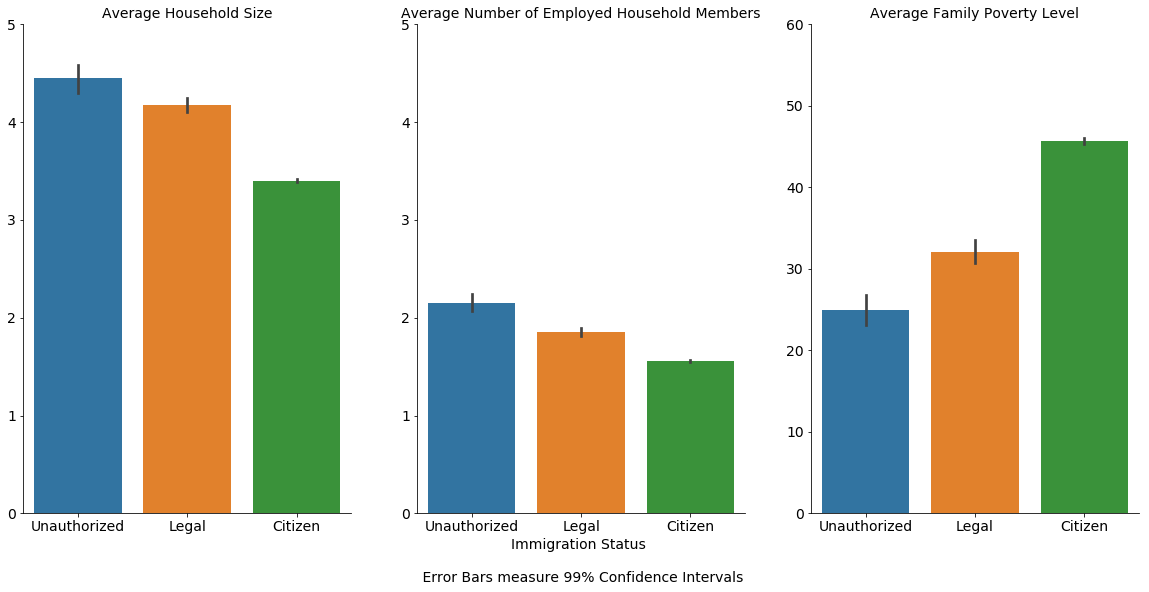

In [105]:
plt.figure(figsize = (20, 9))
plt.subplots_adjust(hspace = .1)
plt.suptitle("", fontsize = 14)

plt.subplot(1, 3, 1)

sns.barplot(x = 'legal', y = 'num_hh', data = features_plots, ci = 99)
plt.ylim(0,5)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Average Household Size', fontsize = 14)
#sw
sns.despine()

plt.subplot(1, 3, 2)

sns.barplot(x = 'legal', y = 'hh_workers', data = features_plots, ci = 99)
plt.ylim(0,5)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('Immigration Status \n \n Error Bars measure 99% Confidence Intervals', fontsize = 14)
plt.title('Average Number of Employed Household Members', fontsize = 14)

sns.despine()

plt.subplot(1, 3, 3)

sns.barplot(x = 'legal', y = 'poverty', data = features_plots, ci = 99)
plt.ylim(0,60)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Average Family Poverty Level', fontsize = 14)

sns.despine()

plt.show()

The average unauthorized noncitizen are poorer and live in larger households than the average legal noncitizen and the average citizen, respectively. They also live in households where a greater number of them have jobs than legal noncitizens and citizens. A caveat: these figures were not created with survey weights and the SIPP tends to have higher estimates of respondents in poverty than other Census Bureau surveys, as noted above. 

The family poverty measure in the SIPP does not match up well with poverty measures in the U.S. Census Bureau's other surveys like the American Community Survey (ACS), the Current Population Survey (CPS), or the decennial official Census. Social scientists note that the SIPP provides lower estimates of aggregate income than the CPS and overestimates incomes at the lower end of the spectrum and under estimates the highest level incomes (Czajka & Denmead (2008) and Shaefer (2015)). See: 
- Czajka, John L., and Gabrielle Denmead. 2008. “Income Data for Policy Analysis: A Comparative Assessment of Eight Surveys.” Washington, D. C.: Mathematica Policy Research. https://www.mathematica.org/our-publications-and-findings/publications/income-data-for-policy-analysis-a-comparative-assessment-of-eight-surveys.
- Shaefer, H. Luke. 2015. “Introduction to The Survey of Income and Program Participation (SIPP).” Presentation, U.S. Census Bureau, May 15. https://ecommons.cornell.edu/handle/1813/40169.

#### Is Everyone in Household Related? Is There a Citizen in the Household?

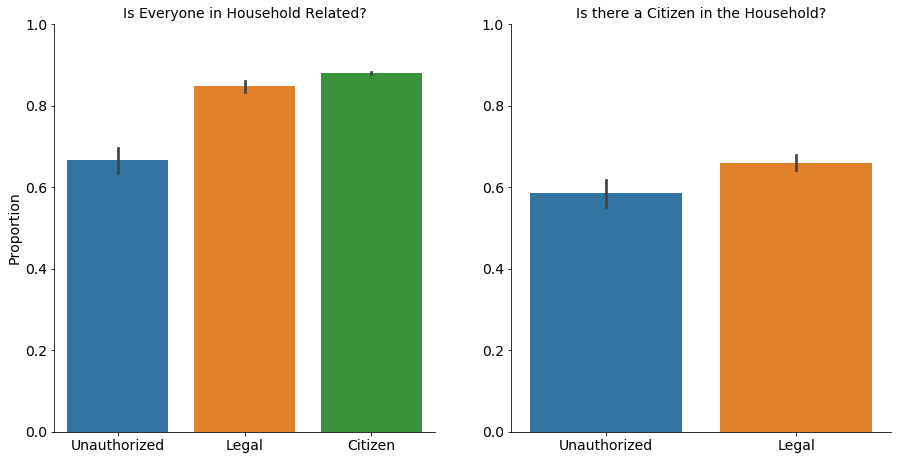

In [106]:
# Plotting 'hh_related' and 'hhcitizen' as barplots

plt.figure(figsize = (15, 7.5))
plt.subplots_adjust(hspace = .1)

plt.subplot(1, 2, 1)


sns.barplot(x = 'legal', y = 'hh_related', data = features_plots, ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Proportion', fontsize = 14)
plt.xlabel('')
plt.title('Is Everyone in Household Related?', fontsize = 14)
sns.despine()

plt.subplot(1, 2, 2)

sns.barplot(x = 'unauthorized', y = 'hhcitizen', data = features_plots, order = [1, 0], ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(2), ('Unauthorized', 'Legal'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Is there a Citizen in the Household?', fontsize = 14)
sns.despine()

plt.show()

The left-hand plot above shows the proportion of people in each class of immigration status who live in a household where everyone is related. Under 70% of unauthorized noncitizens reside in a household where everyone is related, but over 80% of legal noncitizens and citizens live in homes where everyone is related. 

The plot on the right side focuses only on the noncitizen population and shows the proportions of unauthorized and legal noncitizens, respectively, who live with a citizen. Fewer unauthorized noncitizens live with a citizen than lawfully present noncitizens. 

#### Gender, Ethnicity, Age

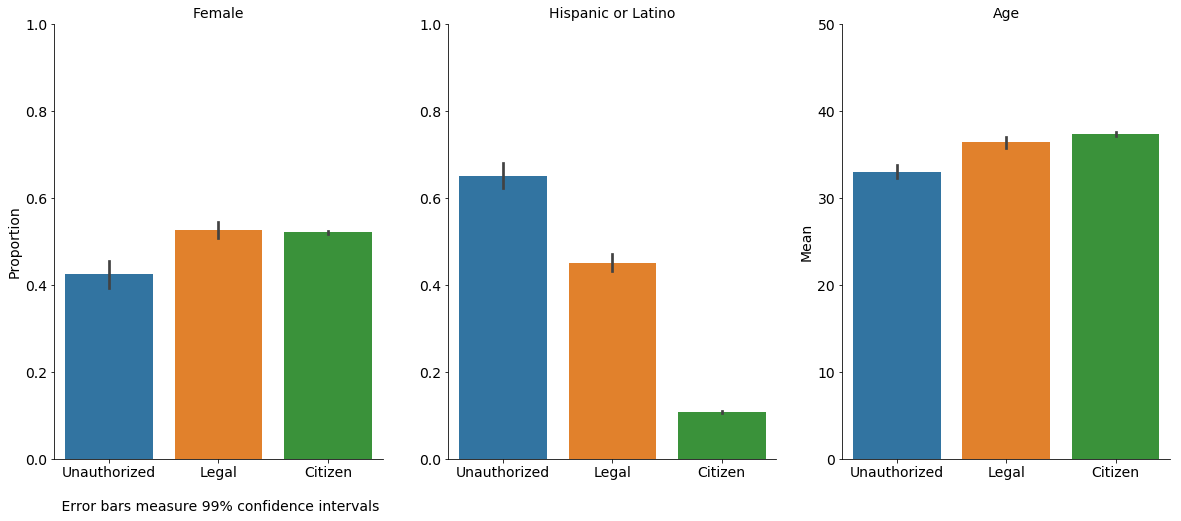

In [107]:
plt.figure(figsize = (20, 8))
plt.subplots_adjust(hspace = .1)
plt.suptitle("", fontsize = 14)

plt.subplot(1, 3, 1)

sns.barplot(x = 'legal', y = 'female', data = features_plots, ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Proportion', fontsize = 14)
plt.xlabel('\n Error bars measure 99% confidence intervals', fontsize = 14)
plt.title('Female', fontsize = 14)
#plt.figtext(0.5, 0.001, 'Error Bars Measure 99% Confidence Intervals', wrap=True, horizontalalignment='center', fontsize=12)

sns.despine()

plt.subplot(1, 3, 2)

sns.barplot(x = 'legal', y = 'hispanic_latino', data = features_plots, ci = 99)
plt.ylim(0,1)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Hispanic or Latino', fontsize = 14)

sns.despine()

plt.subplot(1, 3, 3)
sns.barplot(x = 'legal', y = 'tage', data = features_plots, ci = 99)
plt.ylim(0,50)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Mean', fontsize = 14)
plt.xlabel('')
plt.title('Age', fontsize = 14)

sns.despine()

plt.show()


Compared to legal noncitizens and citizens, the unauthorized population has relatively fewer females. Also, Hispanics and Latinos make up *much* greater shares of the unauthorized and legal noncitizen population than they do among citizens. Unauthorized noncitizens are also younger, on average, than legal noncitizens and citizens. 

#### Education and Length of U.S. Residence

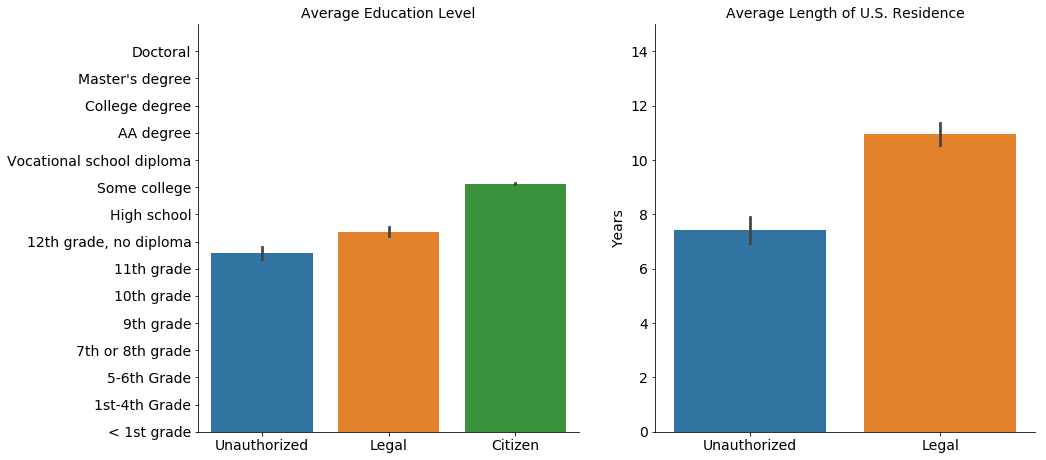

In [108]:
# Plotting education and length of U.S. residence

plt.figure(figsize = (15, 7.5))
plt.subplots_adjust(hspace = .1)

plt.subplot(1, 2, 1)


sns.barplot(x = 'legal', y = 'educ', data = features_plots, ci = 99)
plt.ylim(0,15)
plt.xticks(np.arange(3), ('Unauthorized', 'Legal', 'Citizen'), fontsize = 14)
plt.yticks(np.arange(15), ('< 1st grade', '1st-4th Grade', '5-6th Grade', '7th or 8th grade', '9th grade', '10th grade', 
                           '11th grade', '12th grade, no diploma', 'High school', 'Some college', 
                           'Vocational school diploma', 'AA degree', 'College degree', "Master's degree",
                           "Doctoral"), fontsize = 14)
plt.ylabel('')
plt.xlabel('')
plt.title('Average Education Level', fontsize = 14)
sns.despine()

plt.subplot(1, 2, 2)

sns.barplot(x = 'unauthorized', y = 'years_us', data = features_plots, order = [1, 0], ci = 99)
plt.ylim(0,15)
plt.xticks(np.arange(2), ('Unauthorized', 'Legal'), fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Years', fontsize = 14)
plt.xlabel('')
plt.title('Average Length of U.S. Residence', fontsize = 14)
sns.despine()

plt.show()

Citizens have higher education levels than noncitizens, and especially unauthorized immigrants. The average U.S. citizen has attended college, but not graduated, while legal noncitizens have almost completed high school. Unauthorized immigrants, have the equivalent of an 11th grade education. Unauthorized immigrants have lived in the U.S. an average of seven years while lawfully present immigrants have lived here approximately 11 years. 

#### Insurance 

In [109]:
insurance = features_plots.groupby('legal').insurance.value_counts(normalize = True).rename('proportion').reset_index()

<Figure size 1440x576 with 0 Axes>

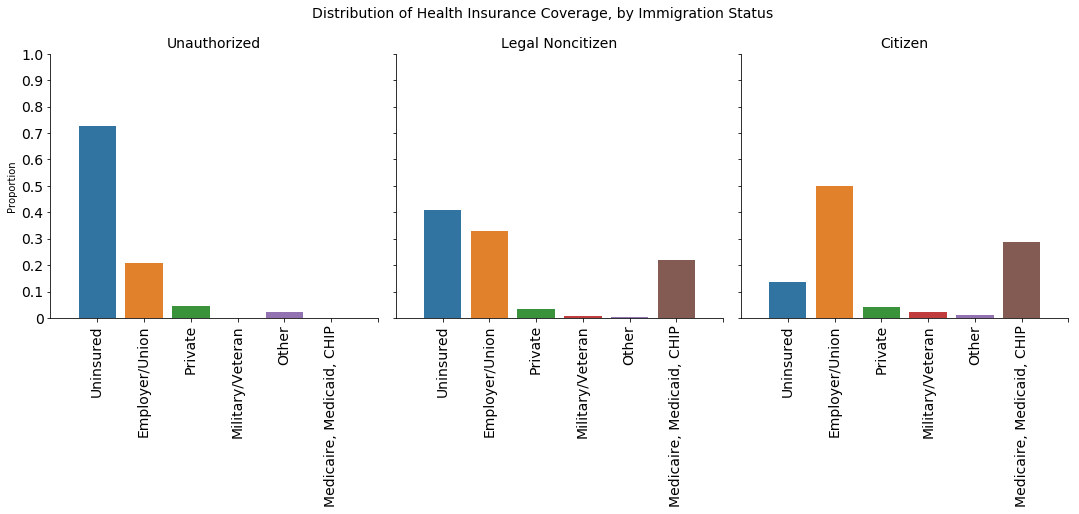

In [110]:
plt.figure(figsize = (20, 8))
p = sns.catplot(x = 'insurance', y = 'proportion', col = 'legal', data = insurance, kind = 'bar')
p.set_axis_labels('', 'Proportion')
p.set(xlim = (-1, 6), ylim = (0, 1), xticks = [0, 1, 2, 3, 4, 5, 6], yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
p.set_xticklabels(['Uninsured', 'Employer/Union', 'Private', 'Military/Veteran', 'Other', 'Medicaire, Medicaid, CHIP'], 
                  rotation = 90, size = 14)
p.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size = 14)
p.axes[0, 0].set_title('Unauthorized', size = 14)
p.axes[0, 1].set_title('Legal Noncitizen', size = 14)
p.axes[0, 2].set_title('Citizen', size = 14) 
p.fig.suptitle('Distribution of Health Insurance Coverage, by Immigration Status', size = 14)
plt.subplots_adjust(top = .85)


There are huge differences between the immigration status groups when it comes to insurance coverage. Almost 20% of citizens are uninsured, while between 40% and 50% of legal noncitizens do not have insurance coverage, but 70% of unauthorized citizens are without coverage! Among lawfully present noncitizens and citizens, the distribution of coverage also varies in meaningful ways. The majority of citizens get their insurance through their employers or from public programs like Medicare, Medicaid, or the Children's Health Insurance Program (CHIP). Fewer lawfully present noncitizens have job-related insurance and fewer are also on public insurance programs. 

#### Employment

In [111]:
jobs = features_plots.groupby('legal').job.value_counts(normalize = True).rename('proportion').reset_index()

<Figure size 1440x576 with 0 Axes>

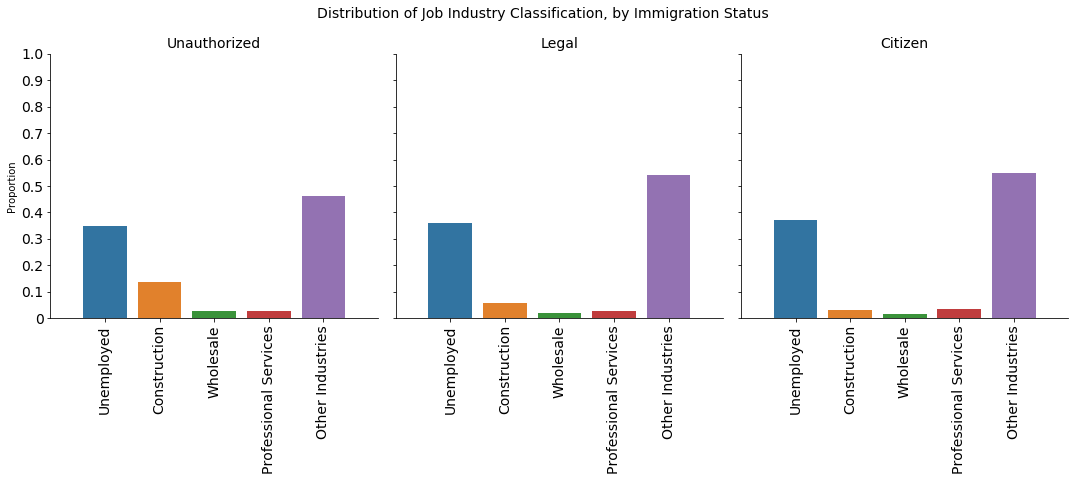

In [112]:
plt.figure(figsize = (20, 8))
p = sns.catplot(x = 'job', y = 'proportion', col = 'legal', data = jobs, kind = 'bar')
p.set_axis_labels('', 'Proportion')
p.set(xlim = (-1, 5), ylim = (0, 1), xticks = [0, 1, 2, 3, 4], 
      yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
p.set_xticklabels(['Unemployed', 'Construction', 'Wholesale', 'Professional Services', 'Other Industries'], 
                  rotation = 90, size = 14)
p.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size = 14)
p.axes[0, 0].set_title('Unauthorized', size = 14)
p.axes[0, 1].set_title('Legal', size = 14)
p.axes[0, 2].set_title('Citizen', size = 14)    
p.fig.suptitle('Distribution of Job Industry Classification, by Immigration Status', size = 14)
plt.subplots_adjust(top = .85)

plt.show()

Comparing the immigration status groups by job industry, there are two meaningful differences between the groups: 1) Fewer unauthorized immigrants are unemployed (though the differences in unemployment rates are less than 10% across the groups), and 2) a greater share of unauthorized immigrants work in construction than legal noncitizens or citizens. 

#### Region of Birth

In [113]:
region = features_plots.groupby('legal').region_birth.value_counts(normalize = True).rename('proportion').reset_index()

<Figure size 1440x576 with 0 Axes>

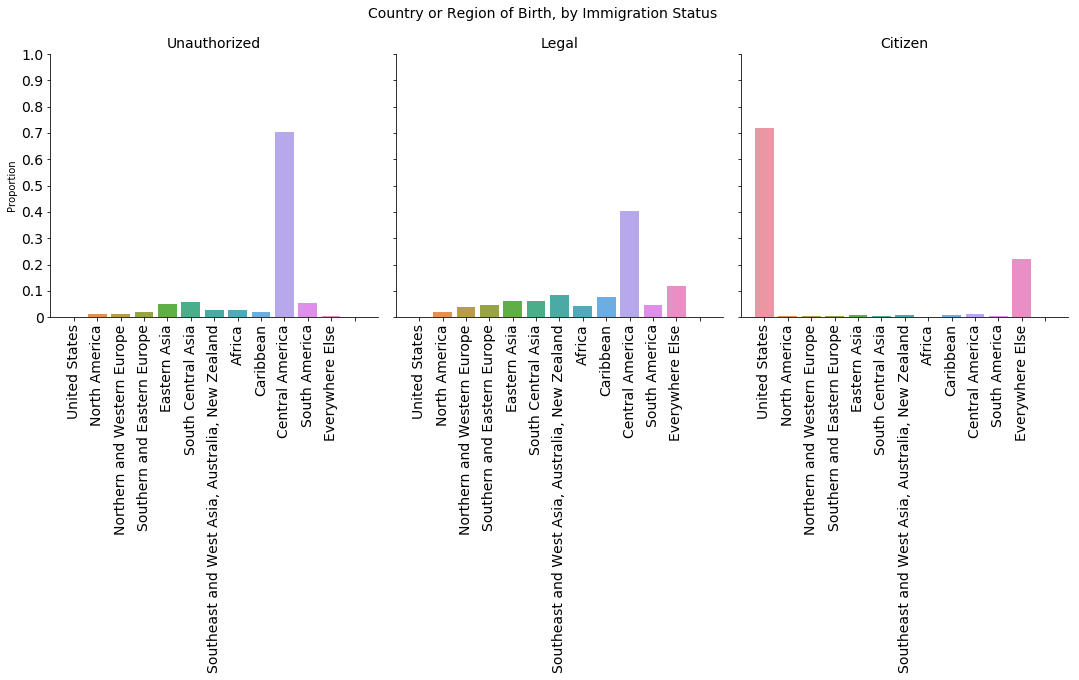

In [114]:
plt.figure(figsize = (20, 8))
p = sns.catplot(x = 'region_birth', y = 'proportion', col = 'legal', data = region, kind = 'bar')
p.set_axis_labels('', 'Proportion')
p.set(xlim = (-1, 13), ylim = (0, 1), xticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
      yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
p.set_xticklabels(['United States', 'North America', 'Northern and Western Europe', 'Southern and Eastern Europe', 
                   'Eastern Asia', 'South Central Asia', 'Southeast and West Asia, Australia, New Zealand', 
                   'Africa', 'Caribbean', 'Central America', 'South America', 'Everywhere Else'], 
                  rotation = 90, size = 14)
p.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size = 14)
p.axes[0, 0].set_title('Unauthorized', size = 14)
p.axes[0, 1].set_title('Legal', size = 14)
p.axes[0, 2].set_title('Citizen', size = 14)    
p.fig.suptitle('Country or Region of Birth, by Immigration Status', size = 14)
plt.subplots_adjust(top = .85)

plt.show()

The strong majority of unauthorized immigrants, roughly 70%, are from Central America and it is likely that most of them are from Mexico. Unfortunately, we are unable to confirm this in the data because the SIPP does not provide country of birth for its respondents in its public use files, with the exception of the United States. The rest of possibilities are regional in nature. 

We see a simiilar trend in lawfully present noncitizens, as almost half of them are also from Central America. Unsurprisingly, almsot 80% of U.S. citizens were born in the United States and between 20-30% are from 'elsewhere.' The 'everywhere else' category is undefined in the SIPP documentation, so we cannot determine precisely where those respondents were born. 

#### English Proficiency

In [115]:
english = features_plots.groupby('legal').english.value_counts(normalize = True).rename('proportion').reset_index()

<Figure size 1440x576 with 0 Axes>

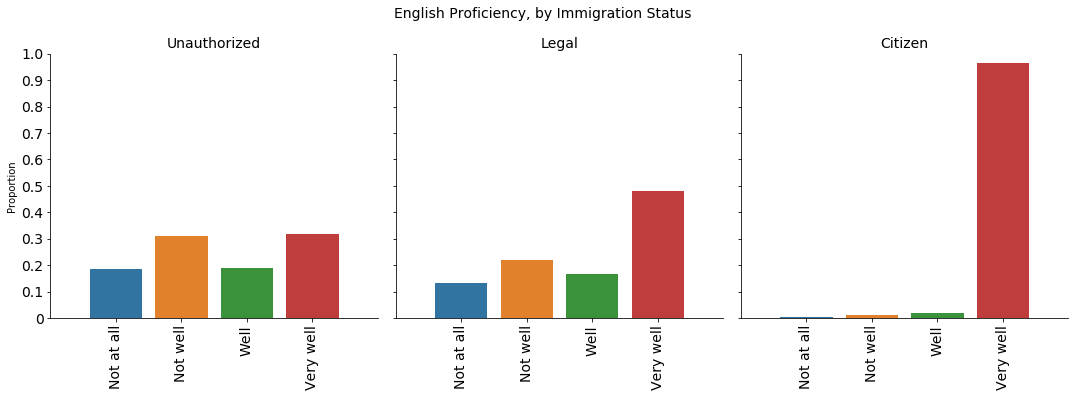

In [115]:
plt.figure(figsize = (20, 8))
p = sns.catplot(x = 'english', y = 'proportion', col = 'legal', data = english, kind = 'bar')
p.set_axis_labels('', 'Proportion')
p.set(xlim = (-1, 4), ylim = (0, 1), xticks = [0, 1, 2, 3], 
      yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
p.set_xticklabels(['Not at all', 'Not well', 'Well', 'Very well'], 
                  rotation = 90, size = 14)
p.set_yticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size = 14)
p.axes[0, 0].set_title('Unauthorized', size = 14)
p.axes[0, 1].set_title('Legal', size = 14)
p.axes[0, 2].set_title('Citizen', size = 14)    
p.fig.suptitle('English Proficiency, by Immigration Status', size = 14)
plt.subplots_adjust(top = .85)

plt.show()

Citizens' proficiency in English is noticeably better than that of noncitizens, but legal noncitizens are marginally better English speakers than unauthorized immigrants. About half of legal noncitizens report speaking English very well, but only 30% of unauthorized immigrants do. 

In [116]:
features_plots.describe()

,pid,unauthorized,legal,num_hh,family_size,hh_related,hh_workers,job,insurance,female,...,poverty,tage,age_group,ageg_gender,age_gender_insurance,region_birth,english,educ,years_us,tfipsst
count,9.850400e+04,6157.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,77747.000000,98504.000000,98504.000000,...,98339.000000,98504.000000,98504.000000,98504.000000,98504.000000,98504.000000,91729.000000,77747.000000,11145.00000,98504.000000
mean,5.534868e+15,0.250771,1.921820,3.452449,3.218428,0.875284,1.582464,2.351088,3.082707,0.519025,...,44.733611,37.196388,2.587134,1.383274,4.752599,4.093001,2.877574,8.990328,13.90830,28.642553
std,2.637884e+15,0.433492,0.321586,1.827870,1.761630,0.330398,1.069915,1.902475,1.926734,0.499640,...,46.121125,22.767129,1.940430,1.927948,8.728368,4.688520,0.492057,2.863846,12.53429,16.214624
min,1.912800e+14,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-189.429508,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,1.000000
25%,3.859251e+15,0.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,2.000000,0.000000,...,17.060241,17.000000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000,5.00000,13.000000
50%,5.664549e+15,0.000000,2.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,1.000000,...,33.591906,37.000000,3.000000,0.000000,0.000000,1.000000,3.000000,9.000000,10.00000,29.000000
75%,7.399254e+15,1.000000,2.000000,4.000000,4.000000,1.000000,2.000000,4.000000,6.000000,1.000000,...,57.675221,55.000000,5.000000,3.000000,6.000000,10.000000,3.000000,11.000000,21.00000,42.000000
max,9.559590e+15,1.000000,2.000000,17.000000,15.000000,1.000000,8.000000,4.000000,6.000000,1.000000,...,905.611416,85.000000,5.000000,5.000000,30.000000,12.000000,3.000000,14.000000,48.00000,56.000000


## Outliers

Machine learning algorithms are sensitive to outliers, so it is important to mitigate them in numeric features, if they exist. I'll do this visually using box plots and will consider outliers to be anything lying outside of both whiskers to be outliers, using the default whisker lengths (1st quartile minus 1.5 times IQR, 3rd Quartile plus 1.5 times IQR). I will use winsorization to cap extreme values. 

In [117]:
numeric_features = ['years_us', 'educ', 'poverty', 'num_hh', 'hh_workers']

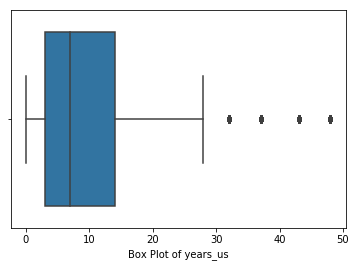

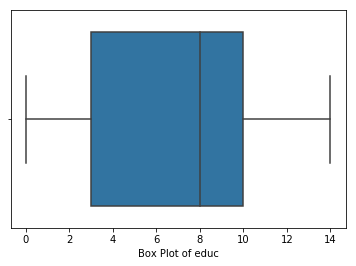

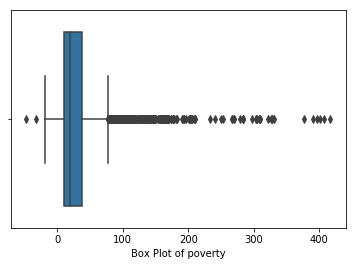

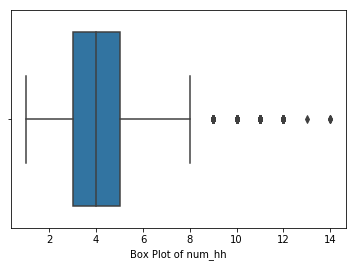

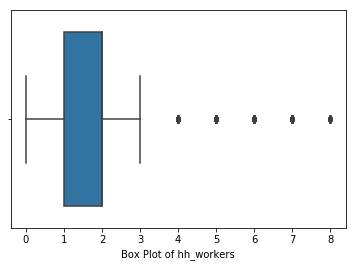

In [118]:
# Checking for outliers in numeric features among noncitizens

for feature in numeric_features:
    sns.boxplot(x = feature, data = sipp_noncitizens)
    plt.xlabel('Box Plot of '+ feature)
    plt.show()

Most of the numeric features have outliers, but the 'poverty' box plot shows extreme poverty levels, indicating very low levels of income. I will mitigate each one below.

Outliers do vary noticeably for most of the features between unauthorized immmigrants and lawfully present noncitizens. 

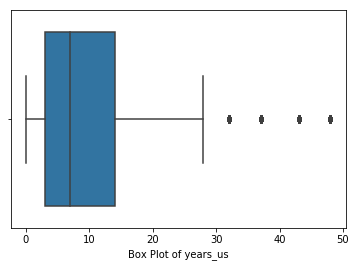

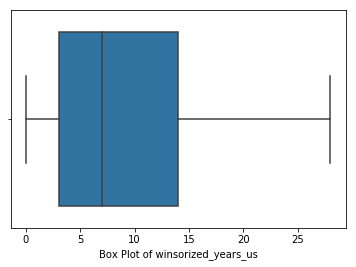

In [119]:
sipp_noncitizens['winsorized_years_us'] = winsorize(sipp_noncitizens['years_us'], (0.0, 0.06))

sns.boxplot(x = 'years_us', data = sipp_noncitizens)
plt.xlabel('Box Plot of years_us')
plt.show()

sns.boxplot(x = 'winsorized_years_us', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_years_us')

plt.show()

The feature measuring how many years noncitizens have lived in the U.S. has extreme values at the right tail of the distribution and I capped it at the 94th percentile.  

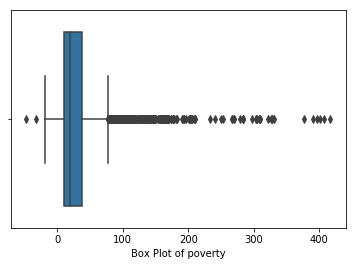

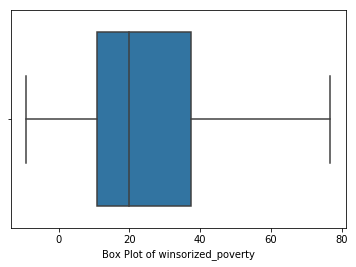

In [120]:
sipp_noncitizens['winsorized_poverty'] = winsorize(sipp_noncitizens['poverty'], (0.001, 0.08))

sns.boxplot(x = 'poverty', data = sipp_noncitizens)
plt.xlabel('Box Plot of poverty')
plt.show()

sns.boxplot(x = 'winsorized_poverty', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_poverty')

plt.show()

The __poverty__ feature, which measures the ratio of family income to the poverty threshold, has extreme values on both ends of the distribution. I capped the left, or lower end, at the 99.99th percentile and the right, or higher end, at the 91st percentile. 

The household size feature, 'num_hh', has extreme ends on the right end of the distribution. I am going to cap the feature at the 96th percentile.

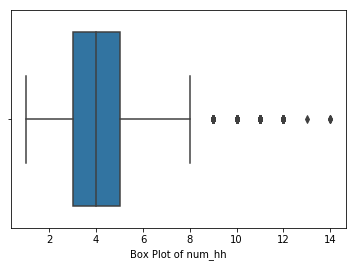

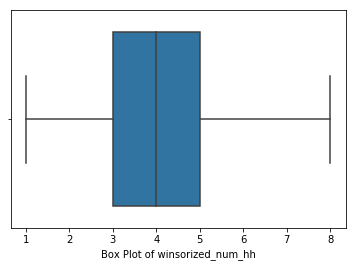

In [121]:
sipp_noncitizens['winsorized_num_hh'] = winsorize(sipp_noncitizens['num_hh'], (0.0, 0.04))

sns.boxplot(x = 'num_hh', data = sipp_noncitizens)
plt.xlabel('Box Plot of num_hh')
plt.show()

sns.boxplot(x = 'winsorized_num_hh', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_num_hh')

plt.show()

The feature measuring the number of workers in the household has extreme measures on the right end of the distribution and I capped it at the 89th percentile. 

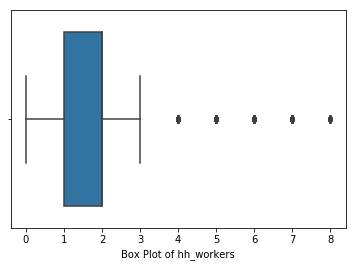

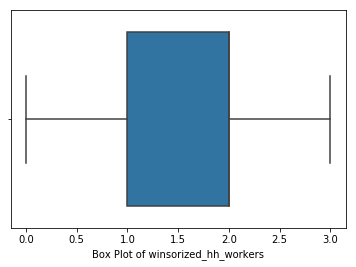

In [122]:
sipp_noncitizens['winsorized_hh_workers'] = winsorize(sipp_noncitizens['hh_workers'], (0.0, 0.11))

sns.boxplot(x = 'hh_workers', data = sipp_noncitizens)
plt.xlabel('Box Plot of hh_workers')
plt.show()

sns.boxplot(x = 'winsorized_hh_workers', data = sipp_noncitizens)
plt.xlabel('Box Plot of winsorized_hh_workers')

plt.show()

## Feature Selection

### Categorical Variables

The target variable and most of the prospective features are categorical, so a correlation matrix using the Pearson's correlation is not adequate to capture the strength of associations between the features and the target. Let us use Cramer's V to measure strengths of association below. I am using code from a thread on [Stack Overflow that corrects for bias that is common in the Cramer's V.](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792) The correction is recommended by Wicher Bergsma in Bergsma, Wicher. 2013. “A Bias-Correction for Cramér’s V and Tschuprow’s T.” *Journal of the Korean Statistical Society* 42 (3): 323–28. https://doi.org/10.1016/j.jkss.2012.10.002.


In [123]:
def cramers_v(confusion_matrix):
    #   calculate Cramers V stat for categorial-categorial association.
    #   uses correction from Bergsma, Wicher, 'A Bias-Correction for Cramer's V and Tschuprow's T, 
    #   Journal of the Korean Statistical Society 42 (2013): 323-328, https://doi.org/10.1016/j.jkss.2012.10.002
    
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [124]:
categorical_list = ['hh_related', 'job', 'insurance', 'female', 'hispanic_latino', 'hhcitizen', 'age_group', 'region_birth', 'english', 'educ', 'state']


for i in categorical_list:
    confusion_matrix = pd.crosstab(sipp_noncitizens['unauthorized'], sipp_noncitizens[i]).as_matrix()
    print("'unauthorized' and " + i + ': {}'.format(cramers_v(confusion_matrix)))

'unauthorized' and hh_related: 0.1987136665792486
'unauthorized' and job: 0.134513569319962
'unauthorized' and insurance: 0.34689886201197256
'unauthorized' and female: 0.09256575637025438
'unauthorized' and hispanic_latino: 0.18706799230523355
'unauthorized' and hhcitizen: 0.07729358930707295
'unauthorized' and age_group: 0.2144373493960914
'unauthorized' and region_birth: 0.24620236217578775
'unauthorized' and english: 0.13364524998685903
'unauthorized' and educ: 0.11257194092293407
'unauthorized' and state: 0.10262046628776147


None of the categorical features are strongly correlated with the unauthorized immigrant measure. The feature with the strongest relationship with the target is the insurance measure, followed by region of birth ('region_birth'), and age group (.21). Even though over 60% of unauthorized immigrants are Hispanic or Latino, that measure is only correlated at .19. The feature measuring whether everyone in the household is related or not is slightly more strongly correlated the target than the ethnicity measure. 

### Continuous and Categorical Relationships

I am going to use Bipoint Serial Correlation to measure the strength of the association between the target variable and the continuous variable features. 

In [125]:
numerical_list = ['winsorized_years_us', 'winsorized_num_hh', 'winsorized_hh_workers', 'winsorized_poverty']


for i in numerical_list:
    pbc = pointbiserialr(sipp_noncitizens['unauthorized'], sipp_noncitizens[i])
    print("'unauthorized' and " + i + ':\n{}\n'.format(pbc))

'unauthorized' and winsorized_years_us:
PointbiserialrResult(correlation=-0.16403734079583648, pvalue=2.0552867277589584e-35)

'unauthorized' and winsorized_num_hh:
PointbiserialrResult(correlation=0.09019259577735428, pvalue=1.0755377321550078e-11)

'unauthorized' and winsorized_hh_workers:
PointbiserialrResult(correlation=0.06583233980254882, pvalue=7.205852714323622e-07)

'unauthorized' and winsorized_poverty:
PointbiserialrResult(correlation=-0.12359274076376381, pvalue=1.0635303293196036e-20)



None of the continuous measures are strongly correlated with the unauthorized measure either. The duration of U.S. residence ('winsorized_years_us') is only correlated with 'unauthorized' at .16. Poverty only is correlated with the target at .12. 

Winsorizing the the dummy measuring the number of workers in the household made me concerned that capping the extreme values caused us to lose explanatory power because unauthorized immigrants live in households with a large number of people with jobs than even legal noncitizens. To see if this is the case, I ran bipoint serial correlations with the non-winsorized versions of the continuous features. Capping extreme values improved the features' relationships with the target variable for three of the four features. As I suspected, it weakened the relationship between 'hh_workers' and 'unauthorized' (non-winsorized version has a correlation of almost .1 vs .66 for the winsorized version). 

In [126]:
numerical_list = ['years_us', 'num_hh', 'hh_workers', 'poverty']


for i in numerical_list:
    pbc = pointbiserialr(sipp_noncitizens['unauthorized'], sipp_noncitizens[i])
    print("'unauthorized' and " + i + ':\n{}\n'.format(pbc))

'unauthorized' and years_us:
PointbiserialrResult(correlation=-0.16357609631133607, pvalue=3.197083974297821e-35)

'unauthorized' and num_hh:
PointbiserialrResult(correlation=0.08593405808161501, pvalue=9.549844029536535e-11)

'unauthorized' and hh_workers:
PointbiserialrResult(correlation=0.09615698430528749, pvalue=4.246647150188171e-13)

'unauthorized' and poverty:
PointbiserialrResult(correlation=-0.09825396058806597, pvalue=1.299005789114536e-13)



### Feature Set

Ranking Strength of Relationships Between Target and Categoricals:
- 'unauthorized' and insurance: 0.34689886201197256
- 'unauthorized' and region_birth: 0.24620236217578775
- 'unauthorized' and age_group: 0.2144373493960914
- 'unauthorized' and hh_related: 0.1987136665792486
- 'unauthorized' and hispanic_latino: 0.18706799230523355
- 'unauthorized' and job: 0.134513569319962
- 'unauthorized' and english: 0.13364524998685903
- 'unauthorized' and educ: 0.11257194092293407
- 'unauthorized' and state: 0.10262046628776147
- 'unauthorized' and female: 0.09256575637025438
- 'unauthorized' and hhcitizen: 0.07729358930707295

Ranking Correlations Between Target and Continuous Features:
- unauthorized and winsorized_years_us: .164
- unauthorized and winsorized_poverty: .12
- unauthorized and hh_workers: .097
- unauthorized and winsorized_num_hh: .09

The pool of features that are based on three major studies estimating the size of the unauthorized immigrant population in the United States is not an impressive one. The measure with the strongest association with the target variable is the insurance measure, which has a Cramer's V statistic of .35, which is objectively rather weak. Of the five features that are below 'insurance' on a ranked list (by strength of association with the target), the Cramer's V statistics ranges from .25 for region of birth to .19 for being Hispanic or Latino. The continuous features also have weak correlations with 'unauthorized,' with length of U.S. residence being the strongest one (a bipoint serial correlation of .16). 

I am going to move forward with the following features for the analysis:
- *insurance*
- *region_birth*
- *age_group*
- *hh_related*: are all household members related?
- *hispanic_latino*
- *job*: categorical classifying job industry (including a level for being unemployed)
- *english*: ordinal measuring English proficiency
- *winsorized_years_us*

These are all categorical measures, so I will covert them to series of dummy variables. The first five features on the list are relatively more strongly correlated with the unauthorized status than the others, but I will also include employment classification and English proficiency. English proficiency shows a clear inverse relationship between speaking the language very well and immigration status and unauthorized workers are more likely to be working in the construction industry than lawfully present noncitizens (and citizens as well).


In [157]:
# Creating a features dataframe

sipp_ncfeatures = sipp_noncitizens[['unauthorized', 'insurance', 'region_birth', 'age_group', 'job', 'english', 'hh_related', 'hispanic_latino', 'state', 'winsorized_years_us' ]]

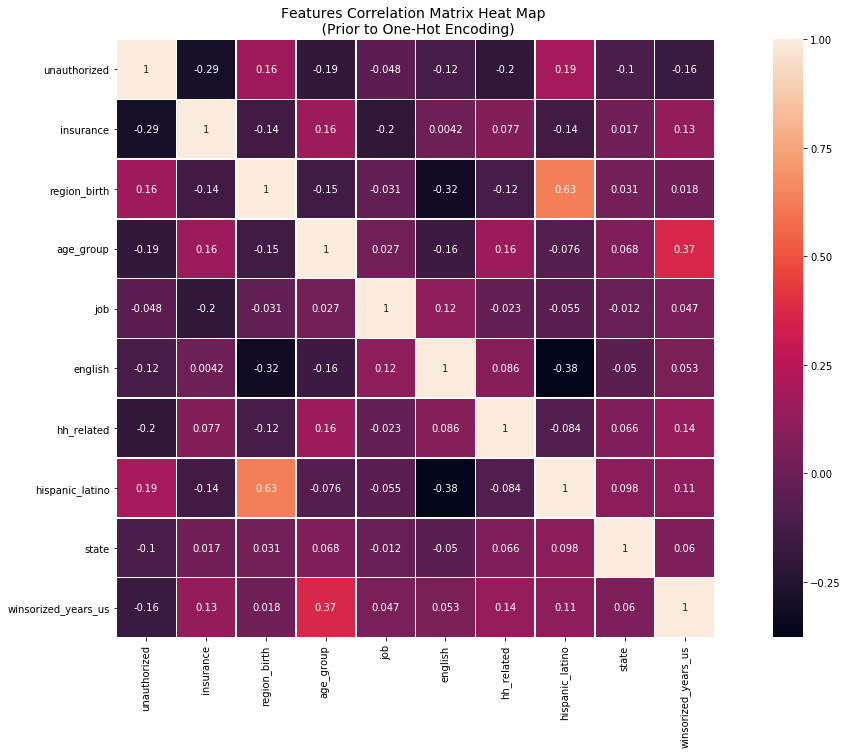

In [163]:
plt.figure(figsize = (21,11))
sns.heatmap(sipp_ncfeatures.corr(), square = True, annot = True, linewidths = .5)

plt.title("Features Correlation Matrix Heat Map \n (Prior to One-Hot Encoding)", fontsize=14)

plt.show()


In [132]:
sipp_ncfeatures = pd.get_dummies(sipp_ncfeatures, columns = ['insurance', 'region_birth', 'age_group', 'job', 'english'], drop_first = True)

In [133]:
sipp_ncfeatures.unauthorized.value_counts()

0.0    4113
1.0    1544
Name: unauthorized, dtype: int64

### Resampling to Mitigate Class Imbalance

Our target has a class imbalance, as roughly 73% of noncitizens are likely legal and 27% are likely unauthorized. I am going to upsample unauthorized immigrants to balance the target in the the training data and then test the model on the test data. 

In [134]:
# Shuffling the dataframe before splitting

sipp_ncfeatures.sample(frac = 1)

y = sipp_ncfeatures.unauthorized
X = sipp_ncfeatures.drop(['pid', 'unauthorized'], axis = 1)

# Setting training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 15)

# Bringing the training data back together

training = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority classes

legal = training[training.unauthorized == 0]
unauth = training[training.unauthorized == 1]

unauth_upsampled = resample(unauth, 
                           replace = True, # sample with replacement
                           n_samples = len(legal), # match number in majority class
                           random_state = 30)

# combine majority and upsampled minority

upsampled = pd.concat([legal, unauth_upsampled])

ytr_upsampled = upsampled.unauthorized
Xtr_upsampled = upsampled.drop('unauthorized', axis = 1)

### Machine Learning: Naive Bayes

I will first use Naive Bayes Classifier with a Bernoulli distribution without tuning any of the hyperparameters to set a benchmark to compare with other models. I will focus on classification accuracy scores, false positive and false negative rates, and sensitivity and specificity rates as metrics to evaluate model performance. 

In [135]:
bnb = BernoulliNB()

scores = cross_val_score(bnb, Xtr_upsampled, ytr_upsampled, cv = 10)
print(scores*100)
print('Mean Cross Validation Accuracy Score is {}%'.format(round(scores.mean()*100, 1)))

[72.65861027 73.11178248 71.45015106 71.45015106 71.90332326 70.39274924
 72.35649547 72.65861027 73.63636364 68.93939394]
Mean Cross Validation Accuracy Score is 71.9%


Our mean accuracy score using 10-fold cross-validation on the training data is 72% and the scores do not fluctuate very much. This does not knock us off of our feet, but considering how poorly the individual features were correlated with our target variable, this is a respectable number. Let us see how it performs on the test set. 

In [136]:
y_pred = bnb.fit(Xtr_upsampled, ytr_upsampled).predict(X_test)

In [137]:
print('Accuracy on the Test Set: {}%'.format(round(accuracy_score(y_test, y_pred)*100, 1)))

Accuracy on the Test Set: 68.9%


The accuracy score on the test set is 68.9%, which is not a huge drop-off from the training set, which suggests that we may not be overfitting the data with our model. But, accuracy scores with an imbalanced target variable are not optimal measures. So, we should explore a confusion matrix to get a better portrait of how the models performs on the data. 

In [138]:
# Confusion_matrix using Pandas Crosstab 
pd.crosstab(y_test, y_pred, margins = True)

col_0,0.0,1.0,All
unauthorized,,,
0.0,547,258,805
1.0,94,233,327
All,641,491,1132


In [139]:
# False Positives 
print('False Positives: {}%'.format((round(((258/491)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((94/641)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((233/327)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((547/805)*100), 1))))

False Positives: 52.5%
False Negatives: 14.7%
Sensitivity: 71.3%
Specificity: 68.0%


Looking more closely, we get 52.5% false positives and get 14.7% false negatives. Most of our predictions of unauthorized immigrants are way off the mark, but we do a reasonably good job of identifying legal noncitizens. Of the unauthorized population, we identify 71% of them as actually unauthorized, which means that we incorrectly identify 29% as legal. On the other side, we identify 68% of legal noncitizens as legal and classify 32% as unauthorized. There is clearly a lot of room for improvement. Maybe tuning the hyperparameters improves the model's performance.  

### Using Bayesian Optimization to Tune the Hyperparameters

To tune the hyperparameters for the models, I am going to use [Hyperopt](https://pdfs.semanticscholar.org/d4f4/9717c9adb46137f49606ebbdf17e3598b5a5.pdf), a package utilizing Bayesian optimization (or Sequential Model Based Optimization (SMBO)) to select the best hyperparameters for a model. I initially used the most common approaches, exhaustive and randomized grid searches (gridsearchcv and randomizedsearch in scikit-learn), but they both took very long times to run. As an experiment, I attempted to tune a Support Vector Classifier first, and both grid and randomized searches took ran for over 24 hours before they were complete. On the other hand, after investing time to learn about SMBO and how to implement it hyperopt, I was able to tune the SVC in approximately 20 minutes. 

The Bayesian method logs evaluation results and forms a probabilistic model that maps hyperparameters to a probability score of the function that is being tuned (the objective function): 

\begin{align*}
p(score|hyperparameters)
\end{align*}


This model is called the "surrogate" for the objective function and it is easier and less time-consuming to optimize than the objective function. In this process, the function works by first randomly selecting a set of hyperparameters to evaluate, storing the results, and using specific criteria to in learning from performance in previous trials to inform how it selects the next set of hyperparameters to evaluate. Hyperopt's default criteria uses an "expected improvement" function to guide its next hyperparameter selection. It performs this process until it reaches a threshold for the number of trials that the user dictates in setting up the algorithm.

Hyperopt offers two estimators to use for the surrogate function, which builds the model mapping hyperparameters to probabilities: the Tree-Structure Parzen Estimator (TPE) and a random search estimator. [The TPE usually performs better than random search and does so in fewer iterations.](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) Thus, I will use TPE.

Because the Bayesian approach learns about the results of the tuning process and updates its selection function as it goes along, it finds optimal hyperparameters in much less time than exhaustive grid searches and randomized searches. 

To user hyperopt, users must:
- define their objective function (the function to be tuned), then
- define and populate the search space with hyperparameters and values to be evaluated
- define the metrics that the objective function returns to the surrogate function 
- select the optimization algorithm and the number of trials that Hyperopt uses as part of the 'fmin' function. (fmin is the optimization function). 


Hyperopt's main algorithm minimizes the objective function that it is fed, hence its name is "fmin." I'm going to maximize the cross-validation accuracy score using the default five folds, so I will instruct it to minimize the negative of the cv score.

In [140]:
# Using Hyperopt to select the best parameters for Naive Bayes

# Defining the objective function. The cross validation algorithm uses five folds for its
# default setting, which I am using here. 

def hyperopt_train_test(params):
    clf = BernoulliNB(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled).mean()

# Populating the search space with hyperparameters and values to evaluate

space = {
    'alpha': hp.uniform('alpha', 0.001, 100.0),
    'fit_prior': hp.choice('fit_prior', [False, True])
}

# Telling Hyperopt to minimize the negative of the CV accuracy score, which will 
# prompt the algorithm to maximize the function rather than minimize it.

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

# Setting random state seed and populating fmin with optimization algorithm (TPE), 
# number of trials (max_evals), and the trials list where evaluation scores are stored.

seed = 90
trials = Trials()

# 'best' will store the optimal set of hyperparameters
best = fmin(f, space, 
            # Selecting TPE as the estimator
            algo = tpe.suggest, 
            
            # Selecting 100 Trials
            max_evals = 100, 
            
            # Telling algorithm where to store trial results
            trials = trials,
            
            # Setting random state seed to reproduce results in the future
            rstate = np.random.RandomState(seed))


print('The best parameters are: {}'.format(space_eval(space, best)))

100%|██████████| 100/100 [00:04<00:00, 22.29it/s, best loss: -0.7162915416844232]
The best parameters are: {'alpha': 1.4257028262609563, 'fit_prior': False}


Hyperopt found that the optimal hyperparameters for Naive Bayes Bernoulli are alpha (La Place smoothing) of 1.425... and fit_prior = false (so NB will use a uniform prior instead of trying to learn the prior probabilities of the classes for *unauthorized*). Below I refit the model to use the best parameters and test it on the test set. 

It returned a cross validation mean accuracy score of 71.6%, as the best loss value above is -.716.... Hyperopt returns a negative value for the accuracy score, even though you set it to negative in the code to ensure that it maximizes accuracy, rather than minimizing it. 

In [141]:
# Refitting the model with the optimal hyperparameters on the training set and then 
# running it on the test set 
bnb_hyperopt = BernoulliNB(alpha = 1.4257028262609563, fit_prior = False)

bnb_hyperopt.fit(Xtr_upsampled, ytr_upsampled)
y_pred = bnb_hyperopt.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.6890459363957597


In [142]:
# Investigating confusion matrix to assess the model's performance

pd.crosstab(y_test, y_pred, margins = True)

col_0,0.0,1.0,All
unauthorized,,,
0.0,547,258,805
1.0,94,233,327
All,641,491,1132


Tuning the alpha (La Place smoothing) parameter nor setting a uniform prior did not change the performance. The confusion matrix is exactly the same as the "untuned" Naive Bayes Bernoulli model. 

While tuning the Naive Bayes Classifier did not improve the model's performance, it does not mean that tuning other machine learning algorithms will lead to similar results. Let us also use Hyperopt to tune K-Nearest Neighbors, Random Forests, and a Gradient Boosting Classifier to see if they improve our model's ability to correctly identity unauthorized noncitizens.  

### K-Nearest Neighbors

For KNN, we will have the optimization algorithm evaluate the following hyperparameters and values:
- n_neighbors: 1 to 20
- weights: uniform or distance
- algorithm: Ball Tree, KD Tree, or brute force search

In [143]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled).mean()

space = {
    'n_neighbors': hp.choice('n_neighbors', range(1, 20)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'algorithm': hp.choice('algorithm', ['ball_tree', 'kd_tree', 'brute']),
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

seed = 90
trials = Trials()
best = fmin(f, space, algo = tpe.suggest, max_evals = 100, trials = trials,
            rstate = np.random.RandomState(seed))
print('The best parameters are: {}'.format(space_eval(space, best)))

100%|██████████| 100/100 [01:19<00:00,  1.26it/s, best loss: -0.828296884863862]
The best parameters are: {'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'distance'}


The best parameters are the brute force search algorithm, 3 neighbors, and distance weights. It achieved a mean of 83% accuracy (best loss value of -.828...).

In [ ]:
# Running the optimal KNN on the test set.

knn =  KNeighborsClassifier(algorithm = 'brute', n_neighbors= 3, weights = 'distance')
print('Accuracy Score on Test Set: {}'.format(knn.fit(Xtr_upsampled, ytr_upsampled).score(X_test, y_test)))

In [ ]:
# Creating a confusion matrix of the true target values in the test set vs the predicted
# ones. 
knn = KNeighborsClassifier(algorithm = 'brute', n_neighbors = 3, weights = 'distance')

y_pred = knn.fit(Xtr_upsampled, ytr_upsampled).predict(X_test)

#confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, margins = True)

In [ ]:
# False Positives 
print('False Positives: {}%'.format((round(((155/286)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((196/846)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((131/327)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((650/805)*100), 1))))

The KNN model fared worse than the Naive Bayes Classifier in a few ways. There is a greater percentage of false positives and false negatives. The model also does a worse job in identifying unauthorized immigrants. On the other hand, it correctly classified more legal noncitizens than Naive Bayes. We will now try Support Vector Classifier.

### Support Vector Machines

In tuning the Support Vector Classifier, we are going to evaluate the following:
- kernels: linear, sigmoid, and rbf
- C (regularization parameter): the algorithm will randomly evaluate values from .001 to 100
- gamma: values along a uniform distribution from .0001 to 100.

I attempted to include the polynomial kernel (and degrees), but neither Hyperopt nor the exhaustive or randomized grid searches were able to efficiently evaluate them. The algorithms would hang, including gridsearch and randomized search algorithms for over 24 hours for each. I was unable to solve the problem in a timely manner and decided to exclude the polynomial kernel. 

In [ ]:
# Tuning SVC

def hyperopt_train_test(params):
    clf = svm.SVC(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled).mean()

space = {
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'rbf']),
    'C': hp.uniform('C', .001, 100),
    'gamma': hp.uniform('gamma', 0.0001, 100),
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

seed = 90
trials = Trials()
best = fmin(f, space, algo = tpe.suggest, max_evals = 100, trials = trials,
            rstate = np.random.RandomState(seed))
print('The best parameters are: {}'.format(space_eval(space, best)))

The optimal set achieves a five-fold cross validation accuracy of about 89% on the training data (best loss: -.89...)

Let's refit the model with the optimal hyperparameters and see how it works on the test set. 

In [ ]:
# Setting the SVC with the optimal set of hyperparameters. 

svc = svm.SVC(kernel = 'rbf', C = 51.33806537406653, gamma = 2.983636770940386)

In [ ]:
# Getting the accuracy score for the tuned SVC on the test set. 

print('Accuracy Score on Test Set: {}%'.format(round(svc.fit(Xtr_upsampled, ytr_upsampled).score(X_test, y_test)*100, 1)))

In [ ]:
# Creating a confusion matrix of the true target values in the test set vs the predicted
# ones. 

y_pred = svc.fit(Xtr_upsampled, ytr_upsampled).predict(X_test)

#confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, margins = True)

In [ ]:
# False Positives 
print('False Positives: {}%'.format((round(((66/125)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((268/1007)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((59/327)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((739/805)*100), 1))))

SVC, after tuning the hyperparameters to find the best fitting model, has average an cross validation accuracy score of about 89%, which is much better than what Naive Bayes achieved. Yet, it only achieves 70.5% accuracy on the test set, which indicates overfitting. If we take a closer look at the predictions in the confusion matrix, we see that SVC does a better job identifying legal noncitizens, but fares worse than KNN or Naive Bayes in other important ways. It fares poorly in identifying unauthorized immigrants, classifying only 18% of unauthorized noncitizens in the test set. We are still seeing over of the positive predictions being incorrectly identified with almost 53% false positives. It also has 27% false negatives, incorrectly identifying unauthorized citizens as having legal status. 

### Random Forest Classifier

For the Random Forest Classifier, we will evaluate the following hyperparameters and their values:
- max depth of the tree: range from 1 to 30
- maximum number of features to consider when making the best split: range from 1 to 30
- number of estimators/number of trees: range from 10 to 500
- criterion measuring the quality of the split: either gini impurity or entropy (information gain).

In [ ]:
# Tuning Random Forest

def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled).mean()

space = {'max_depth': hp.choice('max_depth', range(1,30)), 
         'max_features': hp.choice('max_features', range(1, 10)), 
         'n_estimators': hp.choice('n_estimators', range(10, 500)), 
         'criterion': hp.choice('criterion', ["gini", "entropy"]),
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

seed = 90 
trials = Trials()
best = fmin(f, space, algo = tpe.suggest, max_evals = 100, trials = trials,
            rstate = np.random.RandomState(seed))
print('The best parameters are: {}'.format(space_eval(space, best)))

The model with the optimal hyperparameter set achieves a cross validation score of about 86% ( the 'best loss' above is -.858....).

In [132]:
# Refitting the model with the optimal set of hyperparameters

rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 27, max_features = 6, n_estimators = 130)

In [133]:
# Getting the optimal model's accuracy with the test set data.

print('Accuracy Score on Test Set: {}%'.format((round(rfc.fit(Xtr_upsampled, ytr_upsampled).score(X_test, y_test)*100, 1))))

Accuracy Score on Test Set: 71.6%


In [134]:
# Creating a confusion matrix 

y_pred = rfc.fit(Xtr_upsampled, ytr_upsampled).predict(X_test)

#confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, margins = True)

col_0,0.0,1.0,All
unauthorized,,,
0.0,648,157,805
1.0,159,168,327
All,807,325,1132


In [135]:
# False Positives 
print('False Positives: {}%'.format((round(((156/325)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((158/807)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((169/327)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((649/805)*100), 1))))

False Positives: 48.0%
False Negatives: 19.6%
Sensitivity: 51.7%
Specificity: 80.6%


The tuned random forest classifier has a better performance than KNN or SVC, but it still fares worse than the other models on a pair of metrics. It has the highest accuracy score on the test set of all the models so far, which is about 72%. More importantly, it has a lower percentage of false positives than Naive Bayes and the others (48% compared to NB's 52.5%) and a higher specificity rate than NB, but lower than SVC (SVC's specificity is 91%). 

Unfortunately, it has a lower sensitivity rate than Naive Bayes (51.7% compared to 71.3%) and more false negatives (19.6% compared to 14.7%). 

#### Random Forest Feature Importance

In [140]:
# udfs ----

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [141]:
from sklearn.base import clone 

In [146]:
def drop_col_feat_imp(model, X_train, y_train, random_state = 40):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [147]:
drop_col_feat_imp(rfc, X_train, y_train, random_state = 40)

,feature,feature_importance
0,winsorized_years_us,0.098564
1,state,0.021436
2,hh_related,0.016796
3,job_4.0,0.015470
4,insurance_2.0,0.013039
5,english_1.0,0.011713
6,insurance_6.0,0.010608
7,english_3.0,0.010387
8,hispanic_latino,0.007514
9,english_2.0,0.007293


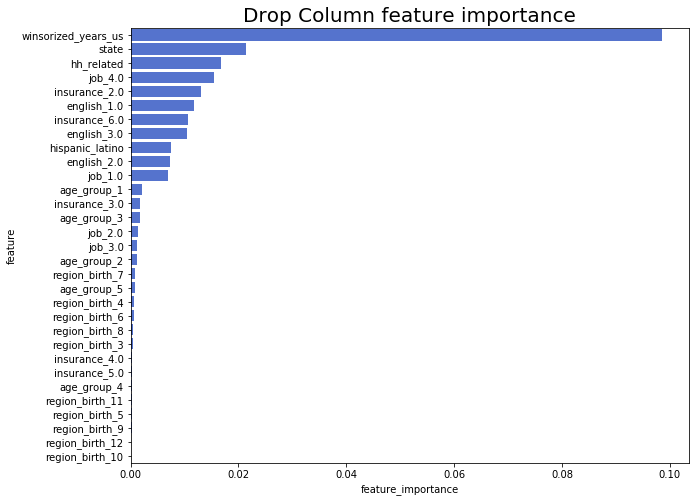

In [150]:
plt.figure(figsize = (10, 8))

drop_imp = drop_col_feat_imp(rfc, X_train, y_train)
var_imp_plot(drop_imp, 'Drop Column Feature Importance')

### Gradient Boosting Classifier

In [ ]:
# Tuning Gradient Boosting Classifier

def hyperopt_train_test(params):
    clf = ensemble.GradientBoostingClassifier(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled, n_jobs = -1).mean()

space = {
    'loss': hp.choice('loss', (['deviance', 'exponential'])),
    'learning_rate': hp.uniform('learning_rate', 0.000001, 1),
    'n_estimators': hp.choice('n_estimators', range(10, 500)),
    'max_depth': hp.choice('max_depth', range(1,30)), 
    'max_features': hp.choice('max_features', range(1, 10))
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

seed = 90
trials = Trials()
best = fmin(f, space, algo = tpe.suggest, max_evals = 100, trials = trials,
            rstate = np.random.RandomState(seed))
print('The best parameters are: {}'.format(space_eval(space, best)))

The tuned gradient boosting classifier achieved an accuracy rate of 87% on a five-fold cross validation on the training data.

In [145]:
gbc = ensemble.GradientBoostingClassifier(learning_rate = 0.7627393057790193, loss = 'deviance', max_depth = 23,
                                         max_features = 9, n_estimators = 399)
print('Accuracy Score on Test Set: {}%'.format((round(gbc.fit(Xtr_upsampled, ytr_upsampled).score(X_test, y_test)*100, 1))))

Accuracy Score on Test Set: 71.8%


In [146]:
y_pred = gbc.fit(Xtr_upsampled, ytr_upsampled).predict(X_test)

#confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, margins = True)

col_0,0.0,1.0,All
unauthorized,,,
0.0,699,106,805
1.0,209,118,327
All,908,224,1132


In [148]:
# False Positives 
print('False Positives: {}%'.format((round(((106/224)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((209/908)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((118/327)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((699/805)*100), 1))))

False Positives: 47.3%
False Negatives: 23.0%
Sensitivity: 36.1%
Specificity: 86.8%


The tuned gradient boosting classifier achieved 71.8% on the test set after achieving an 87% accuracy on the training data. Comparing it to other models, it is also a mixed bag like Random Forest was. But, it also has fewer false positives than Naive Bayes and the other classifiers. It has a very low sensitivity rate, identifying only 36% of unauthorized immigrants in the test set. On the other hand, the specificity is 87%, meaning it does a fairly good job in identifying legal noncitizens. 

### Assessing the Models, In Sum

In [151]:
summary = {'ML Classifier': ['Naive Bayes (Untuned)', 'KNN', 'SVC', 'Random Forest', 'Gradient Boosting'],
           'Accuracy: Training (%)': [72, 83, 89, 86, 87], 
           'Accuracy: Test Set (%)': [69, 69, 71, 72, 72],
           'False Positives (%)': [53, 54, 53, 48, 47],
           'False Negatives (%)': [15, 23, 27, 20, 23],
           'Sensitivity (%)': [71, 40, 18, 52, 36],
           'Specificity (%)': [68, 81, 92, 80, 87]
          }

summary = pd.DataFrame(summary)

print(summary)

           ML Classifier  Accuracy: Training (%)  Accuracy: Test Set (%)  \
0  Naive Bayes (Untuned)                      72                      69   
1                    KNN                      83                      69   
2                    SVC                      89                      71   
3          Random Forest                      86                      72   
4      Gradient Boosting                      87                      72   

   False Positives (%)  False Negatives (%)  Sensitivity (%)  Specificity (%)  
0                   53                   15               71               68  
1                   54                   23               40               81  
2                   53                   27               18               92  
3                   48                   20               52               80  
4                   47                   23               36               87  


In [153]:
from IPython.display import display, HTML

display(HTML(summary.to_html()))

,ML Classifier,Accuracy: Training (%),Accuracy: Test Set (%),False Positives (%),False Negatives (%),Sensitivity (%),Specificity (%)
0,Naive Bayes (Untuned),72,69,53,15,71,68
1,KNN,83,69,54,23,40,81
2,SVC,89,71,53,27,18,92
3,Random Forest,86,72,48,20,52,80
4,Gradient Boosting,87,72,47,23,36,87


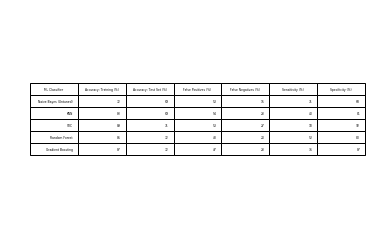

In [154]:
import matplotlib.backends.backend_pdf

table = pd.DataFrame(summary)

fig = plt.figure()

ax=fig.add_subplot(111)

cell_text = []
for row in range(len(table)):
    cell_text.append(table.iloc[row])

ax.table(cellText=cell_text, colLabels=table.columns, loc='center')
ax.axis('off')

pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
pdf.savefig(fig)
pdf.close()

Comparing the models along these metrics, there is not one that did better than the others. The differences in training accuracy and test accuracy indicates that the models were overfitting the data. Naive Bayes, untuned, performed quite well overall compared to the others. It did the best job identifying unauthorized noncitizens (sensitivity and had the fewest false negatives, though it was the worst in identifying lawfully present ones (according to the sensitivity rate). Random Forest and Gradient Boosting Classifier had the fewest false positive and the second least false negative rates, but neither was impressive in their sensitivity rates. 

There is a lot of room for improvement  across the board and before I moved forward with a project that needed an accurate estimate of unauthorized noncitizens in the United States, I would go back and take a deeper dive into the available features. The features used by researchers are weakly correlated with unauthorized status and that probably plays a large role in why the models are not doing as well as I had hoped that they would.

Before I close this capstone, since the models were likely overfitting the data, I will see if I can achieve better results by dropping three features that had the weakest correlations with the target: 'jobs', 'educ', and 'state'. Reducing the dimensionality may improve the models' performance. Since Naive Bayes and Random Forest performed relatively well compared to the others, I will use those them instead of the whole lot. 

In [ ]:
blah blah blah

### Dimensionality Reduction: Removing Jobs Classification, Education, and State of Residence

In [ ]:
# Creating a features dataframe

sipp_ncfeatures = sipp_noncitizens[['unauthorized', 'pid', 'insurance', 'region_birth', 'age_group', 'hh_related', 'hispanic_latino', 'winsorized_years_us' ]]

In [ ]:
sipp_ncfeatures = pd.get_dummies(sipp_ncfeatures, columns = ['insurance', 'region_birth', 'age_group'], drop_first = True)

In [ ]:
### Resampling to mitigate class imbalance in the target

In [ ]:
sipp_ncfeatures.sample(frac = 1)

y = sipp_ncfeatures.unauthorized
X = sipp_ncfeatures.drop(['pid', 'unauthorized'], axis = 1)

# Setting training and testing sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 17)

# Bringing the training data back together

training = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority classes

legal = training[training.unauthorized == 0]
unauth = training[training.unauthorized == 1]

unauth_upsampled = resample(unauth, 
                           replace = True, # sample with replacement
                           n_samples = len(legal), # match number in majority class
                           random_state = 30)

# combine majority and upsampled minority

upsampled = pd.concat([legal, unauth_upsampled])

ytr_upsampled = upsampled.unauthorized
Xtr_upsampled = upsampled.drop('unauthorized', axis = 1)

In [ ]:
# Using Hyperopt to select the best parameters for Naive Bayes

# Defining the objective function. The cross validation algorithm uses five folds for its
# default setting, which I am using here. 

def hyperopt_train_test(params):
    clf = BernoulliNB(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled).mean()

# Populating the search space with hyperparameters and values to evaluate

space = {
    'alpha': hp.uniform('alpha', 0.001, 100.0),
    'fit_prior': hp.choice('fit_prior', [False, True])
}

# Telling Hyperopt to minimize the negative of the CV accuracy score, which will 
# prompt the algorithm to maximize the function rather than minimize it.

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

# Setting random state seed and populating fmin with optimization algorithm (TPE), 
# number of trials (max_evals), and the trials list where evaluation scores are stored.

seed = 90
trials = Trials()

# 'best' will store the optimal set of hyperparameters
best = fmin(f, space, 
            # Selecting TPE as the estimator
            algo = tpe.suggest, 
            
            # Selecting 100 Trials
            max_evals = 100, 
            
            # Telling algorithm where to store trial results
            trials = trials,
            
            # Setting random state seed to reproduce results in the future
            rstate = np.random.RandomState(seed))


print('The best parameters are: {}'.format(space_eval(space, best)))

In [ ]:
# Refitting the model with the optimal hyperparameters on the training set and then 
# running it on the test set 
bnb_hyperopt = BernoulliNB(alpha = 0.8110089100755902, fit_prior = True)

bnb_hyperopt.fit(Xtr_upsampled, ytr_upsampled)
y_pred = bnb_hyperopt.predict(X_test)
print(accuracy_score(y_pred, y_test))

In [ ]:
# Confusion matrix

pd.crosstab(y_test, y_pred, margins = True)

In [ ]:
# False Positives 
print('False Positives: {}%'.format((round(((268/494)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((72/638)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((226/298)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((566/834)*100), 1))))

### Random Forest Classifier

In [ ]:
# Tuning Random Forest

def hyperopt_train_test(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, Xtr_upsampled, ytr_upsampled).mean()

space = {'max_depth': hp.choice('max_depth', range(1,30)), 
         'max_features': hp.choice('max_features', range(1, 10)), 
         'n_estimators': hp.choice('n_estimators', range(10,1000)), 
         'criterion': hp.choice('criterion', ["gini", "entropy"]),
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

seed = 90 
trials = Trials()
best = fmin(f, space, algo = tpe.suggest, max_evals = 100, trials = trials,
            rstate = np.random.RandomState(seed))
print('The best parameters are: {}'.format(space_eval(space, best)))

In [ ]:
# Refitting the model with the optimal set of hyperparameters

rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 27, max_features = 7, n_estimators = 597)

In [ ]:
# Getting the optimal model's accuracy with the test set data.

print('Accuracy Score on Test Set: {}%'.format((round(rfc.fit(Xtr_upsampled, ytr_upsampled).score(X_test, y_test)*100, 1))))

In [ ]:
# Creating a confusion matrix 

y_pred = rfc.fit(Xtr_upsampled, ytr_upsampled).predict(X_test)

#confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, margins = True)

In [ ]:
# False Positives 
print('False Positives: {}%'.format((round(((239/443)*100), 1))))

# False Negatives
print('False Negatives: {}%'.format((round(((94/689)*100), 1))))

# Sensitivity
print('Sensitivity: {}%'.format((round(((204/298)*100), 1))))

# Specificity

print('Specificity: {}%'.format((round(((595/834)*100), 1))))

### Comparing Performances Between Original Model and Revised Models

In [ ]:
# Creating a dataframe to display a table comparing Naive Bayes and Random Forest 
# performances between the original model and the second one with fewer features.

summary_two = {'Metrics': ['Accuracy: Training', 'Accuracy: Test Set', 'False Positives', 'False Negatives', 'Sensitivity', 'Specificity'],
           'Naive Bayes I (%)': [72, 69, 53, 15, 71, 68], 
           'Naive Bayes II (%)': [71, 70, 54, 11, 76, 68],
           'Random Forest I (%)': [86, 72, 49, 20, 52, 80],
           'Random Forest II (%)': [79, 71, 54, 14, 69, 71],
          }

summary_two = pd.DataFrame(summary_two)

summary_two



Reducing the dimensions improved the model performance overall, though not across every metric. The Naive Bayes (untuned) classifier had lower accuracy training scores but higher testing scores. It also had fewer false negatives and higher sensitivity rates. So, it missed the mark on identifying legal noncitizens less often and had more success identifying unauthorized ones. 

The Random Forest Classifier also improved its performance with the revised model on two metrics. It had a higher sensitivity rate, correctly identifying a higher percentage of unauthorized citizens. Unfortunately, it had more false positives, identifying a higher number of legal noncitizens as unauthorized. It also had a lower specificity rate, meaning that it correctly identified a lower proportion of legal noncitizens as legal. 

While the models' performances were disappointing, it revealed that current models on estimating the size of the unauthorized noncitizen population leave a lot of room for improvement. I selected my features from a feature pool taken from studies that are considered the gold standard on this topic. I may have done the best that I could from a mediocre set of features. 

My next steps for this project, since I am working on this for my "day job," would include first revisiting the research on characteristics of the unauthorized population for guidance on what else I should be looking for in the SIPP data and also taking a closer look at the SIPP data to investigate other features that might improve the models' performance that I may have missed. 